In [1]:
# Check GPU availability and setup
import torch
import subprocess
import sys

print("="*60)
print("ENVIRONMENT SETUP")
print("="*60)

# Check GPU
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"✓ GPU Available: {gpu_name}")
    print(f"✓ GPU Memory: {gpu_memory:.1f} GB")
else:
    print("✗ No GPU available - this project requires GPU!")
    print("  Go to Runtime > Change runtime type > GPU (T4 or A100)")

# Check Python version
print(f"\nPython version: {sys.version.split()[0]}")

# Check CUDA
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

ENVIRONMENT SETUP
✓ GPU Available: NVIDIA A100-SXM4-80GB
✓ GPU Memory: 85.2 GB

Python version: 3.12.12
CUDA available: True
CUDA version: 12.6


In [2]:
# Mount Google Drive to save progress (Colab optional)
import os
import pathlib

IN_COLAB = False
try:
    from google.colab import drive  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False

if IN_COLAB:
    drive.mount('/content/drive', force_remount=True)
    DEFAULT_PROJECT_DIR = "/content/drive/MyDrive/adaptive-swe-agent"
else:
    # Local / VS Code / Jupyter
    DEFAULT_PROJECT_DIR = os.path.abspath("./adaptive-swe-agent")

# Allow overriding from environment
PROJECT_DIR = os.environ.get("PROJECT_DIR", DEFAULT_PROJECT_DIR)

# Create required directories (used throughout the notebook)
for sub in ["", "models", "data", "results", "predictions", "evaluation"]:
    p = PROJECT_DIR if sub == "" else os.path.join(PROJECT_DIR, sub)
    os.makedirs(p, exist_ok=True)

print("✓ PROJECT_DIR =", PROJECT_DIR)


Mounted at /content/drive
✓ PROJECT_DIR = /content/drive/MyDrive/adaptive-swe-agent


In [3]:
import os

PRED_DIR = os.path.join(PROJECT_DIR, "predictions")
DATA_DIR = os.path.join(PROJECT_DIR, "data")
RES_DIR  = os.path.join(PROJECT_DIR, "results")
EVAL_DIR = os.path.join(PROJECT_DIR, "evaluation")

os.makedirs(PRED_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(RES_DIR, exist_ok=True)
os.makedirs(EVAL_DIR, exist_ok=True)

ADAPTIVE_PRED_10_JSONL = os.path.join(PRED_DIR, "adaptive_predictions_10.jsonl")

print("✓ Paths initialized")
print("  ADAPTIVE_PRED_10_JSONL =", ADAPTIVE_PRED_10_JSONL)

✓ Paths initialized
  ADAPTIVE_PRED_10_JSONL = /content/drive/MyDrive/adaptive-swe-agent/predictions/adaptive_predictions_10.jsonl


In [4]:
# Cell 3: Install required packages (FIXED)
print("Installing dependencies (this may take 3-5 minutes)...")

# Install core packages
!pip install -q datasets transformers accelerate bitsandbytes
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126
!pip install -q vllm
!pip install -q openai anthropic
!pip install -q pandas numpy scikit-learn xgboost
!pip install -q sentence-transformers
!pip install -q GitPython PyGithub
!pip install -q tqdm wandb

print("✓ Core packages installed")

# Install SWE-bench
!pip install -q swebench

print("✓ SWE-bench installed")

# Verify installations
import datasets
import transformers
import vllm

print("\n" + "="*60)
print("INSTALLATION COMPLETE")
print("="*60)
print(f"✓ Transformers version: {transformers.__version__}")
print(f"✓ Datasets version: {datasets.__version__}")
print(f"✓ vLLM version: {vllm.__version__}")

# Test SWE-bench import (with error handling)
try:
    from swebench.harness.test_spec import TestSpec
    print(f"✓ SWE-bench imported successfully")
except ImportError:
    try:
        import swebench
        print(f"✓ SWE-bench installed (version: {swebench.__version__ if hasattr(swebench, '__version__') else 'unknown'})")
    except:
        print("⚠ SWE-bench installed but import structure may have changed")

print("\n⚠ Note: Dependency warnings above can be safely ignored")
print("   (jedi and pydantic version conflicts won't affect our project)")

Installing dependencies (this may take 3-5 minutes)...
✓ Core packages installed
✓ SWE-bench installed

INSTALLATION COMPLETE
✓ Transformers version: 4.57.3
✓ Datasets version: 4.0.0
✓ vLLM version: 0.12.0
✓ SWE-bench installed (version: 4.1.0)

⚠ Note: Dependency warnings above can be safely ignored
   (jedi and pydantic version conflicts won't affect our project)


In [5]:
# Cell 4: Download SWE-bench Lite dataset (FIXED)
from datasets import load_dataset
import json
import pandas as pd

print("Downloading SWE-bench Lite dataset...")

# Load dataset (300 curated tasks)
dataset = load_dataset("princeton-nlp/SWE-bench_Lite", split="test")

print(f"✓ Loaded {len(dataset)} tasks")

# Save to JSON for easy access
data_file = f"{PROJECT_DIR}/data/swebench_lite.jsonl"
with open(data_file, 'w') as f:
    for item in dataset:
        # Convert to dict properly
        item_dict = {key: item[key] for key in item.keys()}
        f.write(json.dumps(item_dict) + '\n')

print(f"✓ Saved to: {data_file}")

# Inspect first task
print("\n" + "="*60)
print("SAMPLE TASK")
print("="*60)
first_task = dataset[0]
print(f"Instance ID: {first_task['instance_id']}")
print(f"Repository: {first_task['repo']}")
print(f"\nProblem Statement (first 300 chars):")
print(first_task['problem_statement'][:300] + "...")
print(f"\nBase commit: {first_task['base_commit'][:8]}")
print(f"Test patch lines: {len(first_task['test_patch'].split(chr(10)))}")

# Create a small subset for fast iteration (first 10 tasks)
subset_file = f"{PROJECT_DIR}/data/swebench_subset_10.jsonl"
with open(subset_file, 'w') as f:
    for i in range(10):
        item = dataset[i]
        item_dict = {key: item[key] for key in item.keys()}
        f.write(json.dumps(item_dict) + '\n')

print(f"\n✓ Created subset of 10 tasks: {subset_file}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


✓ Loaded 300 tasks
✓ Saved to: /content/drive/MyDrive/adaptive-swe-agent/data/swebench_lite.jsonl

SAMPLE TASK
Instance ID: astropy__astropy-12907
Repository: astropy/astropy

Problem Statement (first 300 chars):
Modeling's `separability_matrix` does not compute separability correctly for nested CompoundModels
Consider the following model:

```python
from astropy.modeling import models as m
from astropy.modeling.separable import separability_matrix

cm = m.Linear1D(10) & m.Linear1D(5)
```

It's sepa...

Base commit: d16bfe05
Test patch lines: 37

✓ Created subset of 10 tasks: /content/drive/MyDrive/adaptive-swe-agent/data/swebench_subset_10.jsonl


In [6]:
# Cell 5: Use GPT-5.1 via OpenAI API
!pip install -q openai

from openai import OpenAI
from google.colab import userdata

# Get API key from Colab secrets
api_key = userdata.get('OPENAI_API_KEY')
client = OpenAI(api_key=api_key)

print("="*60)
print("GPT-5.1 SETUP")
print("="*60)

# Test API
response = client.chat.completions.create(
    model="gpt-5.1",
    messages=[{"role": "user", "content": "Say hello"}],
    max_completion_tokens=50
)

print(f"✓ API connected")
print(f"✓ Model: gpt-5.1")
print(f"✓ Test: {response.choices[0].message.content}")
print(f"✓ Tokens: {response.usage.total_tokens}")

GPT-5.1 SETUP
✓ API connected
✓ Model: gpt-5.1
✓ Test: Hello!
✓ Tokens: 19


In [7]:
# Cell 6: Repository management (ROBUST)
import os
import subprocess
import shutil
import tempfile
from git import Repo

class RepoManager:
    """Manage test repositories for SWE-bench"""

    def __init__(self, base_dir="/content/repos"):
        self.base_dir = base_dir
        os.makedirs(base_dir, exist_ok=True)

    def setup_repository(self, repo_name, commit_hash):
        """Clone and checkout specific commit"""
        repo_path = os.path.join(self.base_dir, repo_name.replace('/', '_'))

        # Clean up if exists
        if os.path.exists(repo_path):
            shutil.rmtree(repo_path)

        repo_url = f"https://github.com/{repo_name}.git"
        try:
            print(f"  Cloning {repo_name} ...")

            # Full clone (safer for commits not in shallow history)
            repo = Repo.clone_from(repo_url, repo_path)

            # Checkout pinned commit
            repo.git.checkout(commit_hash, force=True)

            # Ensure clean state
            repo.git.reset("--hard")
            repo.git.clean("-fd")

            print(f"  ✓ Ready at commit {commit_hash[:8]}")
            return repo_path

        except Exception as e:
            print(f"  ✗ Repo setup error: {type(e).__name__}: {e}")
            return None

    def cleanup_repository(self, repo_path):
        """Remove repository"""
        if repo_path and os.path.exists(repo_path):
            shutil.rmtree(repo_path, ignore_errors=True)

    def get_git_diff(self, repo_path):
        """Get current diff as patch"""
        try:
            result = subprocess.run(
                ["git", "diff"],
                cwd=repo_path,
                capture_output=True,
                text=True,
                timeout=20
            )
            return result.stdout or ""
        except Exception:
            return ""

    def git_apply_check(self, repo_path, patch):
        """Check if a patch applies cleanly (no side effects)."""
        if not patch or not patch.strip():
            return False, "Empty patch"

        patch_file = None
        try:
            with tempfile.NamedTemporaryFile(mode="w", suffix=".patch", delete=False, encoding="utf-8") as f:
                f.write(patch if patch.endswith("\n") else patch + "\n")
                patch_file = f.name

            res = subprocess.run(
                ["git", "apply", "--check", "--verbose", "--recount", patch_file],
                cwd=repo_path,
                capture_output=True,
                text=True,
                timeout=30
            )
            ok = (res.returncode == 0)
            msg = (res.stderr or res.stdout or "").strip()
            return ok, msg
        except subprocess.TimeoutExpired:
            return False, "git apply --check timed out"
        except Exception as e:
            return False, f"{type(e).__name__}: {str(e)[:200]}"
        finally:
            if patch_file and os.path.exists(patch_file):
                try: os.unlink(patch_file)
                except: pass

    def apply_patch(self, repo_path, patch):
        """Apply patch only if it passes --check. Returns (ok, msg)."""
        ok, msg = self.git_apply_check(repo_path, patch)
        if not ok:
            return False, msg

        patch_file = None
        try:
            with tempfile.NamedTemporaryFile(mode="w", suffix=".patch", delete=False, encoding="utf-8") as f:
                f.write(patch if patch.endswith("\n") else patch + "\n")
                patch_file = f.name

            res = subprocess.run(
                ["git", "apply", patch_file],
                cwd=repo_path,
                capture_output=True,
                text=True,
                timeout=30
            )
            ok = (res.returncode == 0)
            msg = (res.stderr or res.stdout or "").strip()
            return ok, msg
        except subprocess.TimeoutExpired:
            return False, "git apply timed out"
        except Exception as e:
            return False, f"{type(e).__name__}: {str(e)[:200]}"
        finally:
            if patch_file and os.path.exists(patch_file):
                try: os.unlink(patch_file)
                except: pass


print("✓ Repository manager initialized")
repo_mgr = RepoManager()

✓ Repository manager initialized


In [8]:
# =============================================================================
# Cell 7 (TRUE SINGLE-PASS BASELINE: 1 LLM call, no repairs) — ROBUST v3
# - One model call per task
# - skips docs/tests/CHANGES
# - ALWAYS includes HEAD + keyword windows
# - truncates context on LINE boundaries (prevents broken anchors)
# - robust patch extraction/normalization
# =============================================================================

import os
import re
import subprocess
import tempfile
from dataclasses import dataclass
from typing import Optional, Tuple, List

@dataclass
class ApplyCheckResult:
    ok: bool
    stderr: str
    stdout: str

class SinglePassBaselineAgent:
    def __init__(
        self,
        client,
        model: str = "gpt-5.1",
        strict_single_file: bool = True,
        do_apply_check: bool = True,
        head_lines: int = 200,
        max_context_chars: int = 32000,
    ):
        self.client = client
        self.model = model
        self.strict_single_file = strict_single_file
        self.do_apply_check = do_apply_check
        self.head_lines = head_lines
        self.max_context_chars = max_context_chars

    def _is_disallowed_target(self, rel_path: str) -> bool:
        if not rel_path:
            return True
        rp = rel_path.replace("\\", "/").lstrip("./")
        if rp == "CHANGES.rst":
            return True
        if rp.startswith("docs/") or rp.startswith("doc/") or "/docs/" in rp:
            return True
        if rp.startswith("test/") or rp.startswith("tests/") or "/tests/" in rp:
            return True
        return False

    def solve_issue(self, task: dict, repo_path: str, max_tokens: int = 4096):
        try:
            problem_statement = task.get("problem_statement") or task.get("problem") or ""
            if not problem_statement:
                return {"patch": "", "success": False, "tokens_used": 0, "target_file": None, "apply_stderr": ""}

            target_file = self._infer_target_file(problem_statement, repo_path)
            if self.strict_single_file and not target_file:
                target_file = self._fallback_target_file(problem_statement, repo_path)

            file_context = self._build_file_context(problem_statement, repo_path, target_file)

            patch, tokens_used = self._generate_patch(
                problem_statement=problem_statement,
                target_file=target_file,
                file_context=file_context,
                max_tokens=max_tokens,
            )
            patch = self._postprocess_patch(patch)

            apply_stderr = ""
            if self.do_apply_check and patch.strip():
                res = self._git_apply_check(repo_path, patch, recount=True)
                success = res.ok
                apply_stderr = (res.stderr or res.stdout or "").strip()
            else:
                success = bool(patch.strip())

            return {
                "patch": patch,
                "success": success,
                "tokens_used": tokens_used,
                "target_file": target_file,
                "apply_stderr": apply_stderr,
            }

        except Exception as e:
            print(f"  ✗ Error in solve_issue: {type(e).__name__}: {e}")
            return {"patch": "", "success": False, "tokens_used": 0, "target_file": None, "apply_stderr": ""}

    def _strict_rules_text(self, target_file: Optional[str]) -> str:
        if not self.strict_single_file:
            return ""
        if target_file:
            return (
                "\nSTRICT RULES:\n"
                f"- You MUST ONLY modify this one file: {target_file}\n"
                "- Do NOT modify tests, docs, CHANGES.rst, or any other file.\n"
                "- Output a single unified diff for that file.\n"
            )
        return (
            "\nSTRICT RULES:\n"
            "- You MUST NOT modify CHANGES.rst or any docs (*.rst, *.md) or any tests.\n"
            "- Only modify the minimum necessary source code file(s).\n"
            "- Keep the patch minimal.\n"
        )

    def _generate_patch(
        self,
        problem_statement: str,
        target_file: Optional[str],
        file_context: str,
        max_tokens: int = 4096,
    ) -> Tuple[str, int]:
        system = "You are an expert software engineer. Return ONLY a valid unified diff patch. No markdown, no commentary."
        strict = self._strict_rules_text(target_file)

        user = (
            "Fix the bug described below by editing the repository.\n\n"
            f"PROBLEM:\n{problem_statement}\n\n"
            f"TARGET FILE (best guess): {target_file}\n"
            f"{strict}\n"
            "REPO CONTEXT (exact content at pinned commit):\n"
            f"{file_context}\n\n"
            "OUTPUT REQUIREMENTS:\n"
            "- Output ONLY a unified diff that `git apply` can apply.\n"
            "- Include diff headers: diff --git / --- / +++\n"
            "- Use correct @@ hunk headers.\n"
            "- Do NOT include markdown fences.\n"
            "- Reuse exact context lines from the provided file content.\n"
        )

        resp = self.client.chat.completions.create(
            model=self.model,
            messages=[{"role": "system", "content": system}, {"role": "user", "content": user}],
            max_completion_tokens=max_tokens,
            temperature=0.2,
        )

        text = resp.choices[0].message.content or ""
        usage = getattr(resp, "usage", None)
        tokens_used = usage.total_tokens if usage else 0
        return text, tokens_used

    def _infer_target_file(self, problem_statement: str, repo_path: str) -> Optional[str]:
        patterns = [
            r"(?:in|file)\s+`([^`]+?\.(?:py|js|ts|java|go|rs|c|cpp|h|hpp))`",
            r"(?:in|file)\s+([A-Za-z0-9_\-./]+?\.(?:py|js|ts|java|go|rs|c|cpp|h|hpp))",
            r"(`)([A-Za-z0-9_\-./]+?\.(?:py|js|ts|java|go|rs|c|cpp|h|hpp))\1",
        ]

        for pat in patterns:
            m = re.search(pat, problem_statement)
            if m:
                cand = m.group(1) if m.lastindex == 1 else m.group(2)
                cand = (cand or "").strip()
                if cand and os.path.exists(os.path.join(repo_path, cand)) and not self._is_disallowed_target(cand):
                    return cand

        identifiers = re.findall(r"\b[A-Za-z_][A-Za-z0-9_]{3,}\b", problem_statement)
        stop = {"this", "that", "when", "then", "true", "false", "none"}
        identifiers = [w for w in identifiers if w.lower() not in stop][:10]

        best_file, best_hits = None, 0
        skip_dir_markers = ["/.git/", "/venv/", "/.venv/", "/node_modules/", "/dist/", "/build/", "/.tox/"]

        for root, _, files in os.walk(repo_path):
            root_norm = root.replace("\\", "/")
            if any(m in root_norm for m in skip_dir_markers):
                continue

            for fn in files:
                if not fn.endswith((".py", ".js", ".ts", ".java", ".go", ".rs", ".c", ".cpp", ".h", ".hpp")):
                    continue

                fp = os.path.join(root, fn)
                rel = os.path.relpath(fp, repo_path).replace("\\", "/")

                if self._is_disallowed_target(rel):
                    continue

                try:
                    with open(fp, "r", encoding="utf-8", errors="ignore") as f:
                        txt = f.read()
                    hits = sum(1 for w in identifiers if w in txt)
                    if hits > best_hits:
                        best_hits, best_file = hits, rel
                except Exception:
                    continue

        return best_file

    def _fallback_target_file(self, problem_statement: str, repo_path: str) -> Optional[str]:
        identifiers = re.findall(r"\b[A-Za-z_][A-Za-z0-9_]{3,}\b", problem_statement)
        stop = {"this", "that", "when", "then", "true", "false", "none"}
        identifiers = [w for w in identifiers if w.lower() not in stop][:12]

        best_file, best_hits = None, 0
        skip_dir_markers = ["/.git/", "/venv/", "/.venv/", "/node_modules/", "/dist/", "/build/", "/.tox/"]

        for root, _, files in os.walk(repo_path):
            root_norm = root.replace("\\", "/")
            if any(m in root_norm for m in skip_dir_markers):
                continue

            for fn in files:
                if not fn.endswith((".py", ".js", ".ts", ".java", ".go", ".rs", ".c", ".cpp", ".h", ".hpp")):
                    continue

                fp = os.path.join(root, fn)
                rel = os.path.relpath(fp, repo_path).replace("\\", "/")

                if self._is_disallowed_target(rel):
                    continue

                try:
                    with open(fp, "r", encoding="utf-8", errors="ignore") as f:
                        txt = f.read()
                    hits = sum(1 for w in identifiers if w in txt)
                    if hits > best_hits:
                        best_hits, best_file = hits, rel
                except Exception:
                    continue

        return best_file

    def _build_file_context(self, problem_statement: str, repo_path: str, target_file: Optional[str]) -> str:
        if not target_file:
            return "No specific target file inferred."

        abs_path = os.path.join(repo_path, target_file)
        if not os.path.exists(abs_path):
            return f"Target file not found on disk: {target_file}"

        with open(abs_path, "r", encoding="utf-8", errors="ignore") as f:
            lines = f.readlines()

        total_lines = len(lines)
        head_n = min(self.head_lines, total_lines)

        parts: List[str] = []
        parts.append(f"FILE: {target_file}\n")
        parts.append(f"----- BEGIN FILE (HEAD LINES 1-{head_n}) -----\n")
        parts.extend(lines[:head_n])
        parts.append("----- END FILE (HEAD) -----\n\n")

        identifiers = re.findall(r"\b[A-Za-z_][A-Za-z0-9_]{3,}\b", problem_statement)
        stop = {"this", "that", "when", "then", "true", "false", "none"}
        identifiers = [w for w in identifiers if w.lower() not in stop][:12]

        hit_idxs = [i for i, ln in enumerate(lines) if any(w in ln for w in identifiers)][:6]

        def clamp(a, lo, hi):
            return max(lo, min(hi, a))

        chunks: List[Tuple[int, int]] = []
        for idx in hit_idxs:
            start = clamp(idx - 140, 0, total_lines)
            end = clamp(idx + 260, 0, total_lines)
            if end <= head_n:
                continue
            start = max(start, head_n)
            chunks.append((start, end))

        chunks.sort()
        merged = []
        for s, e in chunks:
            if not merged or s > merged[-1][1]:
                merged.append([s, e])
            else:
                merged[-1][1] = max(merged[-1][1], e)

        if merged:
            for s, e in merged:
                parts.append(f"----- LINES {s+1}-{e} -----\n")
                parts.extend(lines[s:e])
                parts.append("\n")
        else:
            tail_n = min(240, total_lines - head_n) if total_lines > head_n else 0
            if tail_n > 0:
                start = total_lines - tail_n
                parts.append(f"----- BEGIN FILE (TAIL LINES {start+1}-{total_lines}) -----\n")
                parts.extend(lines[start:])
                parts.append("----- END FILE (TAIL) -----\n")

        # LINE-BOUNDARY truncation (safer than char slicing)
        context = "".join(parts)
        if self.max_context_chars and len(context) > self.max_context_chars:
            # rebuild until cap
            out = []
            n = 0
            for chunk in parts:
                if n + len(chunk) > self.max_context_chars:
                    break
                out.append(chunk)
                n += len(chunk)
            out.append("\n----- [CONTEXT TRUNCATED] -----\n")
            context = "".join(out)

        return context

    def _postprocess_patch(self, patch: str) -> str:
        patch = self._extract_unified_diff(patch)
        patch = patch.replace("\r\n", "\n").replace("\r", "\n").strip("\n") + "\n" if patch else ""
        return patch

    def _extract_unified_diff(self, text: str) -> str:
        if not text:
            return ""
        # remove markdown fences
        text = re.sub(r"^\s*```(?:diff)?\s*\n", "", text, flags=re.MULTILINE)
        text = re.sub(r"\n\s*```\s*$", "", text, flags=re.MULTILINE)

        # keep from first diff header
        m = re.search(r"(?m)^diff --git ", text)
        if not m:
            return ""
        text = text[m.start():]

        # minimal sanity: must include file headers + hunks
        if ("--- " not in text) or ("+++ " not in text) or ("@@" not in text):
            return ""
        return text

    def _git_apply_check(self, repo_path: str, patch: str, recount: bool = False) -> ApplyCheckResult:
        if not patch.strip():
            return ApplyCheckResult(False, "Empty patch", "")

        with tempfile.NamedTemporaryFile(mode="w", suffix=".patch", delete=False, encoding="utf-8") as f:
            f.write(patch if patch.endswith("\n") else patch + "\n")
            tmp = f.name

        try:
            cmd = ["git", "apply", "--check", "--verbose"]
            if recount:
                cmd.append("--recount")
            p = subprocess.run(cmd + [tmp], cwd=repo_path, capture_output=True, text=True, timeout=30)
            return ApplyCheckResult(ok=(p.returncode == 0), stderr=p.stderr or "", stdout=p.stdout or "")
        except subprocess.TimeoutExpired:
            return ApplyCheckResult(False, "git apply --check timed out", "")
        finally:
            try:
                os.unlink(tmp)
            except Exception:
                pass


print("Initializing GPT-5.1 SINGLE-PASS baseline agent (1 call) — robust context + patch extraction...")
agent = SinglePassBaselineAgent(
    client,
    model="gpt-5.1",
    strict_single_file=True,
    do_apply_check=True,
    head_lines=200,
    max_context_chars=32000,
)
print("✓ Agent ready")

Initializing GPT-5.1 SINGLE-PASS baseline agent (1 call) — robust context + patch extraction...
✓ Agent ready


In [9]:
# =============================================================================
# Cell 8: Run baseline on subset (works with the agent above)
# =============================================================================

import json
import time
import pandas as pd

with open(f"{PROJECT_DIR}/data/swebench_subset_10.jsonl") as f:
    tasks = [json.loads(line) for line in f]

print(f"Running baseline on {len(tasks)} tasks")
print("Note: First clone per repo takes 1-2 minutes (downloads full history)")
print("="*60)

predictions = []
results = []

for i, task in enumerate(tasks):
    print(f"\n[{i+1}/{len(tasks)}] {task['instance_id']}")
    print(f"Repo: {task['repo']}")

    try:
        repo_path = repo_mgr.setup_repository(task['repo'], task['base_commit'])
        if not repo_path:
            print("  ✗ Skipping (repo setup failed)")
            predictions.append({
                "instance_id": task["instance_id"],
                "model_patch": "",
                "model_name_or_path": "gpt-5.1-baseline"
            })
            results.append({
                "instance_id": task["instance_id"],
                "repo": task["repo"],
                "success": False,
                "has_patch": False,
                "patch_length": 0,
                "tokens_used": 0,
                "duration": 0
            })
            continue

        start_time = time.time()
        result = agent.solve_issue(task, repo_path)
        duration = time.time() - start_time

        print("target_file:", result.get("target_file"))
        print("has_diff:", "diff --git" in (result.get("patch") or ""))
        print("apply_stderr:", (result.get("apply_stderr") or "")[:400])


        predictions.append({
            "instance_id": task["instance_id"],
            "model_patch": result["patch"],
            "model_name_or_path": "gpt-5.1-baseline"
        })

        results.append({
            "instance_id": task["instance_id"],
            "repo": task["repo"],
            "success": result["success"],
            "has_patch": bool(result["patch"]),
            "patch_length": len(result["patch"]),
            "tokens_used": result["tokens_used"],
            "duration": duration
        })

        print(f"  ✓ Completed in {duration:.1f}s")
        print(f"  Patch: {'Yes' if result['patch'] else 'No'} ({len(result['patch'])} chars)")
        print(f"  Tokens: {result['tokens_used']}")

        repo_mgr.cleanup_repository(repo_path)

    except Exception as e:
        print(f"  ✗ Error: {e}")
        import traceback
        traceback.print_exc()

        predictions.append({
            "instance_id": task["instance_id"],
            "model_patch": "",
            "model_name_or_path": "gpt-5.1-baseline"
        })
        results.append({
            "instance_id": task["instance_id"],
            "repo": task["repo"],
            "success": False,
            "has_patch": False,
            "patch_length": 0,
            "tokens_used": 0,
            "duration": 0
        })

pred_file = f"{PROJECT_DIR}/predictions/baseline_subset.jsonl"
with open(pred_file, "w") as f:
    for pred in predictions:
        f.write(json.dumps(pred) + "\n")

df_results = pd.DataFrame(results)
df_results.to_csv(f"{PROJECT_DIR}/results/baseline_summary.csv", index=False)

print("\n" + "="*60)
print("BASELINE RESULTS")
print("="*60)
print(f"Tasks completed: {len(results)}")
print(f"Patches generated: {df_results['has_patch'].sum()}")
print(f"Success rate: {df_results['success'].mean():.1%}")
print(f"Avg tokens: {df_results['tokens_used'].mean():.0f}")
print(f"Avg time: {df_results['duration'].mean():.1f}s")
print(f"Total time: {df_results['duration'].sum():.1f}s")
print(f"\n✓ Saved: {pred_file}")


Running baseline on 10 tasks
Note: First clone per repo takes 1-2 minutes (downloads full history)

[1/10] astropy__astropy-12907
Repo: astropy/astropy
  Cloning astropy/astropy ...
  ✓ Ready at commit d16bfe05
target_file: astropy/modeling/core.py
has_diff: True
apply_stderr: Checking patch astropy/modeling/core.py...
Hunk #1 succeeded at 12 (offset -2 lines).
Hunk #2 succeeded at 28 (offset -4 lines).
Hunk #3 succeeded at 39 (offset -4 lines).
Hunk #4 succeeded at 48 (offset -4 lines).
Hunk #5 succeeded at 57 (offset -4 lines).
Hunk #6 succeeded at 204 (offset -2 lines).
Hunk #7 succeeded at 222 (offset -3 lines).
error: while searching for:
    def _create_bounding_b
  ✓ Completed in 18.7s
  Patch: Yes (4218 chars)
  Tokens: 3753

[2/10] astropy__astropy-14182
Repo: astropy/astropy
  Cloning astropy/astropy ...
  ✓ Ready at commit a5917978
target_file: astropy/extern/jquery/data/js/jquery.dataTables.js
has_diff: False
apply_stderr: 
  ✓ Completed in 42.2s
  Patch: No (0 chars)
  Tok

In [10]:
# =============================================================================
# Cell 7.5: Verify Context Being Sent to GPT-5.1 (SinglePassBaselineAgent)
# =============================================================================
import json
import os

print("="*60)
print("DIAGNOSTIC: Verify Baseline Target + Context Snippet")
print("="*60)

# Load a task
with open(f"{PROJECT_DIR}/data/swebench_subset_10.jsonl") as f:
    tasks = [json.loads(line) for line in f]

task = tasks[0]  # First task

print(f"\nTask: {task['instance_id']}")
print("Problem statement (first 200 chars):")
print(f"{task.get('problem_statement','')[:200]}...")

# Setup repo
repo_path = repo_mgr.setup_repository(task['repo'], task['base_commit'])
if not repo_path:
    raise RuntimeError("Repo setup failed")

problem_statement = task.get("problem_statement") or task.get("problem") or ""

# Infer target file (same logic as baseline)
target_file = agent._infer_target_file(problem_statement, repo_path)
if agent.strict_single_file and not target_file:
    target_file = agent._fallback_target_file(problem_statement, repo_path)

print(f"\n{'='*60}")
print(f"Target file inferred: {target_file}")
print(f"{'='*60}")

# Show actual file stats (full file on disk)
if target_file:
    full_path = os.path.join(repo_path, target_file)
    if os.path.exists(full_path):
        with open(full_path, "r", encoding="utf-8", errors="ignore") as f:
            full_content = f.read()
        full_lines = full_content.splitlines()

        print("\nFULL FILE stats (on disk):")
        print(f"  Total characters: {len(full_content)}")
        print(f"  Total lines: {len(full_lines)}")
        print(f"  First line: {full_lines[0][:100] if full_lines else '(empty)'}")
        print(f"  Last line: {full_lines[-1][:100] if full_lines else '(empty)'}")
    else:
        print(f"\n✗ Target file not found on disk: {full_path}")

# Show what baseline sends as context (excerpt/snippet)
file_context = agent._build_file_context(problem_statement, repo_path, target_file)

print(f"\n{'='*60}")
print("CONTEXT SNIPPET SENT TO MODEL (first 2000 chars)")
print(f"{'='*60}")
print(file_context[:2000])
print("\n...")

print(f"\nContext snippet length: {len(file_context)} chars")

# Cleanup
repo_mgr.cleanup_repository(repo_path)

print(f"\n{'='*60}")
print("VERIFICATION COMPLETE")
print("="*60)



DIAGNOSTIC: Verify Baseline Target + Context Snippet

Task: astropy__astropy-12907
Problem statement (first 200 chars):
Modeling's `separability_matrix` does not compute separability correctly for nested CompoundModels
Consider the following model:

```python
from astropy.modeling import models as m
from astropy.mo...
  Cloning astropy/astropy ...
  ✓ Ready at commit d16bfe05

Target file inferred: astropy/modeling/core.py

FULL FILE stats (on disk):
  Total characters: 175823
  Total lines: 4473
  First line: # Licensed under a 3-clause BSD style license - see LICENSE.rst
  Last line:     return model

CONTEXT SNIPPET SENT TO MODEL (first 2000 chars)
FILE: astropy/modeling/core.py
----- BEGIN FILE (HEAD LINES 1-200) -----
# Licensed under a 3-clause BSD style license - see LICENSE.rst

"""
This module defines base classes for all models.  The base class of all
models is `~astropy.modeling.Model`. `~astropy.modeling.FittableModel` is
the base class for all fittable models. Fittable mod

In [11]:
# =============================================================================
# Cell 7.7: Debug SinglePassBaselineAgent (FULL WORKING)
# =============================================================================
import json
import os

# Load one task to debug
with open(f"{PROJECT_DIR}/data/swebench_subset_10.jsonl") as f:
    tasks = [json.loads(line) for line in f]

task = tasks[5]  # pick any index you want

print(f"Testing: {task['instance_id']}")
print("="*60)

# -----------------------------
# 1) Clone repo & infer target file (same as baseline)
# -----------------------------
repo_path = repo_mgr.setup_repository(task['repo'], task['base_commit'])
if not repo_path:
    raise RuntimeError("Repo setup failed")

problem_statement = task.get("problem_statement") or task.get("problem") or ""

target_file = agent._infer_target_file(problem_statement, repo_path)
if agent.strict_single_file and not target_file:
    target_file = agent._fallback_target_file(problem_statement, repo_path)

print(f"\nTarget file: {target_file}")

file_context = agent._build_file_context(problem_statement, repo_path, target_file)
print(f"Context snippet length: {len(file_context)} chars")

print("\n" + "="*60)
print("CONTEXT SNIPPET SENT (first 1200 chars):")
print("="*60)
print(file_context[:1200])
print("\n...")

# -----------------------------
# 2) Call GPT-5.1 exactly once (same prompt shape as baseline)
# -----------------------------
raw_text, tokens_used = agent._generate_patch(
    problem_statement=problem_statement,
    target_file=target_file,
    file_context=file_context,
    max_tokens=4096,
)

print("\n" + "="*60)
print("RAW GPT RESPONSE (first 1200 chars):")
print("="*60)
print((raw_text or "")[:1200])
print("\nTokens used:", tokens_used)

# -----------------------------
# 3) Normalize patch (same as baseline)
# -----------------------------
patch = agent._postprocess_patch(raw_text)

print("\n" + "="*60)
print("NORMALIZED PATCH (first 1200 chars):")
print("="*60)
print((patch or "")[:1200])
print("\nHas diff header:", "diff --git" in (patch or ""))

# -----------------------------
# 4) Apply-check (same as baseline scoring)
# -----------------------------
if patch.strip():
    res = agent._git_apply_check(repo_path, patch, recount=True)
    print("\n" + "="*60)
    print("GIT APPLY --CHECK RESULT:")
    print("="*60)
    print("OK:", res.ok)
    print("STDERR (first 1200 chars):")
    print((res.stderr or "")[:1200])
else:
    print("\nNo patch generated after normalization (empty).")

# -----------------------------
# Cleanup
# -----------------------------
repo_mgr.cleanup_repository(repo_path)



Testing: astropy__astropy-7746
  Cloning astropy/astropy ...
  ✓ Ready at commit d5bd3f68

Target file: cextern/wcslib/C/wcs.c
Context snippet length: 11072 chars

CONTEXT SNIPPET SENT (first 1200 chars):
FILE: cextern/wcslib/C/wcs.c
----- BEGIN FILE (HEAD LINES 1-200) -----
/*============================================================================

  WCSLIB 5.19 - an implementation of the FITS WCS standard.
  Copyright (C) 1995-2018, Mark Calabretta

  This file is part of WCSLIB.

  WCSLIB is free software: you can redistribute it and/or modify it under the
  terms of the GNU Lesser General Public License as published by the Free
  Software Foundation, either version 3 of the License, or (at your option)
  any later version.

  WCSLIB is distributed in the hope that it will be useful, but WITHOUT ANY
  WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS
  FOR A PARTICULAR PURPOSE.  See the GNU Lesser General Public License for
  more details.

  You should h

In [12]:
# =============================================================================
# Cell 14: Validate These Patches Apply (ROBUST + CONSISTENT)
# - Reads saved predictions JSONL
# - Re-checks each patch with: git apply --check --verbose --recount
# - Uses UTF-8 when writing patch tempfiles
# - Prints concise errors + final apply rate
# =============================================================================

import json
import subprocess
import tempfile
import os

print("="*60)
print("VALIDATING BASELINE PATCHES (git apply --check --verbose --recount)")
print("="*60)

pred_path = f"{PROJECT_DIR}/predictions/baseline_subset.jsonl"
task_path = f"{PROJECT_DIR}/data/swebench_subset_10.jsonl"

with open(pred_path) as f:
    preds = [json.loads(line) for line in f]

with open(task_path) as f:
    tasks = [json.loads(line) for line in f]

task_lookup = {t["instance_id"]: t for t in tasks}

apply_results = []
checked = 0

for i, pred in enumerate(preds[:10]):
    instance_id = pred.get("instance_id")
    patch = pred.get("model_patch", "") or ""

    if not instance_id:
        print(f"[{i+1}/10] ✗ Missing instance_id in predictions row")
        apply_results.append(False)
        continue

    if not patch.strip():
        print(f"[{i+1}/10] {instance_id}: ✗ No patch")
        apply_results.append(False)
        continue

    task = task_lookup.get(instance_id)
    if not task:
        print(f"[{i+1}/10] {instance_id}: ✗ Task not found in dataset file")
        apply_results.append(False)
        continue

    repo_path = repo_mgr.setup_repository(task["repo"], task["base_commit"])
    if not repo_path:
        print(f"[{i+1}/10] {instance_id}: ✗ Repo setup failed")
        apply_results.append(False)
        continue

    checked += 1

    # Write patch to a temp file (UTF-8)
    patch_file = None
    try:
        with tempfile.NamedTemporaryFile(mode="w", suffix=".patch", delete=False, encoding="utf-8") as f:
            f.write(patch if patch.endswith("\n") else patch + "\n")
            patch_file = f.name

        # Consistent check flags
        cmd = ["git", "apply", "--check", "--verbose", "--recount", patch_file]
        result = subprocess.run(
            cmd,
            cwd=repo_path,
            capture_output=True,
            text=True
        )

        applies = (result.returncode == 0)
        apply_results.append(applies)

        if applies:
            print(f"[{i+1}/10] {instance_id}: ✓ APPLIES!")
        else:
            stderr = (result.stderr or "").strip().replace("\n", " ")
            if len(stderr) > 220:
                stderr = stderr[:220] + "..."
            print(f"[{i+1}/10] {instance_id}: ✗ {stderr}")

    finally:
        if patch_file and os.path.exists(patch_file):
            try:
                os.unlink(patch_file)
            except Exception:
                pass
        repo_mgr.cleanup_repository(repo_path)

print("\n" + "="*60)
print("RESULTS")
print("="*60)

apply_count = sum(1 for x in apply_results if x)
# denominator: only those that had a patch and were checked
denom = checked if checked > 0 else 1

print(f"Patches checked: {checked}")
print(f"Patches that apply: {apply_count}/{checked} ({apply_count/denom*100:.0f}%)")
print(f"✓ Used predictions: {pred_path}")


VALIDATING BASELINE PATCHES (git apply --check --verbose --recount)
  Cloning astropy/astropy ...
  ✓ Ready at commit d16bfe05
[1/10] astropy__astropy-12907: ✗ Checking patch astropy/modeling/core.py... Hunk #1 succeeded at 12 (offset -2 lines). Hunk #2 succeeded at 28 (offset -4 lines). Hunk #3 succeeded at 39 (offset -4 lines). Hunk #4 succeeded at 48 (offset -4 lines). Hunk ...
[2/10] astropy__astropy-14182: ✗ No patch
  Cloning astropy/astropy ...
  ✓ Ready at commit 7269fa3e
[3/10] astropy__astropy-14365: ✗ Checking patch astropy/time/formats.py... error: while searching for: # Licensed under a 3-clause BSD style license - see LICENSE.rst import datetime import fnmatch import re import time import warnings from collections ...
  Cloning astropy/astropy ...
  ✓ Ready at commit b16c7d12
[4/10] astropy__astropy-14995: ✓ APPLIES!
  Cloning astropy/astropy ...
  ✓ Ready at commit c76af9ed
[5/10] astropy__astropy-6938: ✓ APPLIES!
  Cloning astropy/astropy ...
  ✓ Ready at commit d5bd3f6

In [13]:
# Cell 14.5: Inspect Actual Patch Content
import json

with open(f"{PROJECT_DIR}/predictions/baseline_subset.jsonl") as f:
    preds = [json.loads(line) for line in f]

# Check first patch in detail
pred = preds[0]  # astropy__astropy-12907
patch = pred['model_patch']

print("="*60)
print(f"Task: {pred['instance_id']}")
print("="*60)
print("FULL PATCH:")
print(patch)
print("\n" + "="*60)

# Check for specific issues
lines = patch.split('\n')
print(f"\nTotal lines: {len(lines)}")
print("\nLines 15-20 (where corruption occurs at line 18):")
for i in range(14, min(20, len(lines))):
    print(f"{i+1}: {repr(lines[i])}")

Task: astropy__astropy-12907
FULL PATCH:
diff --git a/astropy/modeling/core.py b/astropy/modeling/core.py
index 4c9a4f0..e5a6f4d 100644
--- a/astropy/modeling/core.py
+++ b/astropy/modeling/core.py
@@ -14,6 +14,7 @@ represent either a single model, or a "model set" representing multiple copies
 of the same type of model, but with potentially different values of the
 parameters in each model making up the set.
 """
+
 # pylint: disable=invalid-name, protected-access, redefined-outer-name
 import abc
 import copy
@@ -31,6 +32,7 @@ from itertools import chain
 
 import numpy as np
 
+from astropy.modeling.separable import separability_matrix
 from astropy.utils import indent, metadata
 from astropy.table import Table
 from astropy.units import Quantity, UnitsError, dimensionless_unscaled
@@ -41,7 +43,8 @@ from astropy.utils.codegen import make_function_with_signature
 from astropy.nddata.utils import add_array, extract_array
 from .utils import (combine_labels, make_binary_operator_eval,


In [14]:
# -----------------------------------------------------------------------------
# CELL 9: Real Feature Extraction
# -----------------------------------------------------------------------------

import json
import pandas as pd
import numpy as np
from pathlib import Path
import os

def extract_code_metrics(problem_statement):
    """Extract concrete, measurable metrics from problem statement"""

    return {
        # Text complexity
        'char_count': len(problem_statement),
        'word_count': len(problem_statement.split()),
        'line_count': len(problem_statement.split('\n')),
        'avg_word_length': np.mean([len(w) for w in problem_statement.split()]) if problem_statement.split() else 0,

        # Content indicators
        'has_code_block': int('```' in problem_statement),
        'code_block_count': problem_statement.count('```') // 2,
        'has_traceback': int('traceback' in problem_statement.lower()),
        'has_error': int('error' in problem_statement.lower()),
        'has_exception': int('exception' in problem_statement.lower()),

        # Complexity keywords
        'mentions_multiple_files': int(problem_statement.lower().count('file') > 1),
        'mentions_test': int('test' in problem_statement.lower()),
        'mentions_regression': int('regression' in problem_statement.lower()),
        'mentions_version': int('version' in problem_statement.lower()),

        # Technical indicators
        'has_function_name': int('def ' in problem_statement or '()' in problem_statement),
        'has_class_name': int('class ' in problem_statement),
        'has_import': int('import ' in problem_statement),
        'stack_trace_lines': problem_statement.count('File "'),
    }

def extract_repo_features(repo_name, all_tasks):
    """Extract repository features from dataset distribution (no hardcoding)"""

    repo_tasks = [t for t in all_tasks if t['repo'] == repo_name]

    return {
        'repo_task_count': len(repo_tasks),
        'repo_prevalence': len(repo_tasks) / len(all_tasks) if all_tasks else 0,
    }

print("="*60)
print("EXTRACTING FEATURES FROM REAL DATA")
print("="*60)

# Load data
with open(f"{PROJECT_DIR}/data/swebench_subset_10.jsonl") as f:
    tasks = [json.loads(line) for line in f]

with open(f"{PROJECT_DIR}/data/swebench_lite.jsonl") as f:
    all_tasks = [json.loads(line) for line in f]

df_baseline = pd.read_csv(f"{PROJECT_DIR}/results/baseline_summary.csv")

# Extract features for each task
features_list = []

for task in tasks:
    problem_metrics = extract_code_metrics(task['problem_statement'])
    repo_features = extract_repo_features(task['repo'], all_tasks)
    baseline = df_baseline[df_baseline['instance_id'] == task['instance_id']].iloc[0]

    feature_dict = {
        'instance_id': task['instance_id'],
        'repo': task['repo'],
        **problem_metrics,
        **repo_features,
        'tokens_used': baseline['tokens_used'],
        'duration': baseline['duration'],
        'patch_length': baseline['patch_length'],
    }

    features_list.append(feature_dict)

df_features = pd.DataFrame(features_list)
df_features.to_csv(f"{PROJECT_DIR}/data/task_features_real.csv", index=False)

print(f"✓ Extracted {len(df_features)} task features")
print(f"✓ Features: {len([c for c in df_features.columns if c not in ['instance_id', 'repo', 'tokens_used', 'duration', 'patch_length']])}")

# Show correlations
feature_cols = [c for c in df_features.columns if c not in
                ['instance_id', 'repo', 'tokens_used', 'duration', 'patch_length']]

correlations = df_features[feature_cols + ['tokens_used']].corr()['tokens_used'].drop('tokens_used')

print("\n" + "="*60)
print("TOP FEATURES CORRELATED WITH COMPUTE")
print("="*60)
print(correlations.abs().sort_values(ascending=False).head(10))

print(f"\n✓ Saved: {PROJECT_DIR}/data/task_features_real.csv")

EXTRACTING FEATURES FROM REAL DATA
✓ Extracted 10 task features
✓ Features: 19

TOP FEATURES CORRELATED WITH COMPUTE
stack_trace_lines    0.580170
has_class_name       0.426346
mentions_test        0.421395
has_traceback        0.377168
has_import           0.351709
has_error            0.337863
has_function_name    0.276330
code_block_count     0.245548
repo_task_count      0.223526
has_code_block       0.223526
Name: tokens_used, dtype: float64

✓ Saved: /content/drive/MyDrive/adaptive-swe-agent/data/task_features_real.csv


In [15]:
# -----------------------------------------------------------------------------
# CELL 10: Train Complexity Predictor with Cross-Validation
# -----------------------------------------------------------------------------

from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib

print("="*60)
print("TRAINING COMPLEXITY PREDICTOR")
print("="*60)

# Load features
df = pd.read_csv(f"{PROJECT_DIR}/data/task_features_real.csv")

feature_cols = [c for c in df.columns if c not in
                ['instance_id', 'repo', 'tokens_used', 'duration', 'patch_length']]

X = df[feature_cols].values
y = df['tokens_used'].values

print(f"Samples: {len(X)}, Features: {len(feature_cols)}")
print(f"Target range: {y.min():.0f} - {y.max():.0f} tokens")

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Cross-validation
print("\n" + "="*60)
print("5-FOLD CROSS-VALIDATION")
print("="*60)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)
}

best_model = None
best_score = -np.inf

for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=kfold, scoring='r2', n_jobs=-1)
    print(f"{name}: R² = {scores.mean():.3f} (+/- {scores.std():.3f})")

    if scores.mean() > best_score:
        best_score = scores.mean()
        best_model = model

# Train final model
print(f"\nTraining final model: {type(best_model).__name__}")
best_model.fit(X_scaled, y)
y_pred = best_model.predict(X_scaled)

print(f"R²: {r2_score(y, y_pred):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y, y_pred)):.1f} tokens")
print(f"MAE: {mean_absolute_error(y, y_pred):.1f} tokens")

# Feature importance
if hasattr(best_model, 'feature_importances_'):
    importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\n" + "="*60)
    print("TOP 10 FEATURES")
    print("="*60)
    print(importance.head(10).to_string(index=False))

# Save
joblib.dump(best_model, f"{PROJECT_DIR}/models/complexity_predictor.pkl")
joblib.dump(scaler, f"{PROJECT_DIR}/models/feature_scaler.pkl")
joblib.dump(feature_cols, f"{PROJECT_DIR}/models/feature_names.pkl")

print(f"\n✓ Models saved to {PROJECT_DIR}/models/")

print("\n" + "!"*60)
print("⚠️  Training on 10 samples - expand to 50+ for production")
print("!"*60)

TRAINING COMPLEXITY PREDICTOR
Samples: 10, Features: 19
Target range: 3753 - 8989 tokens

5-FOLD CROSS-VALIDATION
Random Forest: R² = -16.200 (+/- 15.983)
Gradient Boosting: R² = -39.598 (+/- 53.256)

Training final model: RandomForestRegressor
R²: 0.727
RMSE: 829.1 tokens
MAE: 703.9 tokens

TOP 10 FEATURES
                feature  importance
        avg_word_length    0.288553
             word_count    0.178078
      stack_trace_lines    0.108005
             line_count    0.089755
             char_count    0.084815
         has_class_name    0.067982
       code_block_count    0.061766
          mentions_test    0.029244
        repo_prevalence    0.027302
mentions_multiple_files    0.016037

✓ Models saved to /content/drive/MyDrive/adaptive-swe-agent/models/

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
⚠️  Training on 10 samples - expand to 50+ for production
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


In [16]:
# =============================================================================
# CELL A: Create 50-task subset with good diversity
# =============================================================================

import json
import random
from collections import defaultdict, Counter

print("="*60)
print("CREATING 50-TASK SUBSET")
print("="*60)

# Load full dataset
with open(f"{PROJECT_DIR}/data/swebench_lite.jsonl") as f:
    all_tasks = [json.loads(line) for line in f]

print(f"Total tasks available: {len(all_tasks)}")

# Group by repository
tasks_by_repo = defaultdict(list)
for task in all_tasks:
    tasks_by_repo[task['repo']].append(task)

print(f"Unique repositories: {len(tasks_by_repo)}")

# Strategy: Sample up to 5 tasks per repo for diversity
selected_tasks = []
random.seed(42)  # Reproducibility

# Sort repos by number of tasks (prioritize diverse repos)
sorted_repos = sorted(tasks_by_repo.items(), key=lambda x: len(x[1]), reverse=True)

for repo, repo_tasks in sorted_repos:
    # Take up to 5 tasks from each repo
    sample_size = min(5, len(repo_tasks))
    sampled = random.sample(repo_tasks, sample_size)
    selected_tasks.extend(sampled)

    if len(selected_tasks) >= 50:
        break

# Take exactly 50
selected_tasks = selected_tasks[:50]

# Save subset
subset_file = f"{PROJECT_DIR}/data/swebench_subset_50.jsonl"
with open(subset_file, 'w') as f:
    for task in selected_tasks:
        f.write(json.dumps(task) + '\n')

print(f"\n✓ Created subset with {len(selected_tasks)} tasks")
print(f"✓ Saved: {subset_file}")

# Show distribution
repo_counts = Counter(t['repo'] for t in selected_tasks)
print("\n" + "="*60)
print("REPOSITORY DISTRIBUTION")
print("="*60)
for repo, count in repo_counts.most_common(15):
    print(f"  {repo}: {count} tasks")

print(f"\nTotal unique repos: {len(repo_counts)}")
print(f"Avg tasks per repo: {len(selected_tasks) / len(repo_counts):.1f}")

CREATING 50-TASK SUBSET
Total tasks available: 300
Unique repositories: 12

✓ Created subset with 50 tasks
✓ Saved: /content/drive/MyDrive/adaptive-swe-agent/data/swebench_subset_50.jsonl

REPOSITORY DISTRIBUTION
  django/django: 5 tasks
  sympy/sympy: 5 tasks
  matplotlib/matplotlib: 5 tasks
  scikit-learn/scikit-learn: 5 tasks
  pytest-dev/pytest: 5 tasks
  sphinx-doc/sphinx: 5 tasks
  astropy/astropy: 5 tasks
  psf/requests: 5 tasks
  pylint-dev/pylint: 5 tasks
  pydata/xarray: 5 tasks

Total unique repos: 10
Avg tasks per repo: 5.0


In [17]:
# =============================================================================
# CELL B: Run baseline on 50 tasks (~25-30 minutes)
# =============================================================================

import json
import time
import pandas as pd
import torch
from tqdm import tqdm

print("\n" + "="*60)
print("RUNNING BASELINE ON 50 TASKS")
print("="*60)
print("Estimated time: 25-30 minutes")
print("You can monitor progress below")
print("="*60 + "\n")

# Load tasks
with open(f"{PROJECT_DIR}/data/swebench_subset_50.jsonl") as f:
    tasks = [json.loads(line) for line in f]

predictions = []
results = []

start_time = time.time()

for i, task in enumerate(tasks):
    print(f"\n[{i+1}/50] {task['instance_id']}")
    print(f"Repo: {task['repo']}")

    try:
        # Setup repository
        repo_path = repo_mgr.setup_repository(task['repo'], task['base_commit'])

        if not repo_path:
            print("  ✗ Skipping (repo setup failed)")
            predictions.append({
                'instance_id': task['instance_id'],
                'model_patch': '',
                'model_name_or_path': 'baseline_qwen3b'
            })
            results.append({
                'instance_id': task['instance_id'],
                'repo': task['repo'],
                'success': False,
                'has_patch': False,
                'patch_length': 0,
                'tokens_used': 0,
                'duration': 0
            })
            continue

        # Run agent
        task_start = time.time()
        result = agent.solve_issue(task, repo_path)
        duration = time.time() - task_start

        # Save prediction
        predictions.append({
            'instance_id': task['instance_id'],
            'model_patch': result['patch'],
            'model_name_or_path': 'baseline_qwen3b'
        })

        # Save result
        results.append({
            'instance_id': task['instance_id'],
            'repo': task['repo'],
            'success': result['success'],
            'has_patch': bool(result['patch']),
            'patch_length': len(result['patch']),
            'tokens_used': result['tokens_used'],
            'duration': duration
        })

        print(f"  ✓ Completed in {duration:.1f}s")
        print(f"  Patch: {'Yes' if result['patch'] else 'No'} ({len(result['patch'])} chars)")
        print(f"  Tokens: {result['tokens_used']}")

        # Progress update every 10 tasks
        if (i + 1) % 10 == 0:
            elapsed = time.time() - start_time
            avg_time = elapsed / (i + 1)
            remaining = avg_time * (50 - i - 1)
            print(f"\n{'='*60}")
            print(f"PROGRESS: {i+1}/50 complete ({(i+1)/50*100:.0f}%)")
            print(f"Elapsed: {elapsed/60:.1f} min, Remaining: {remaining/60:.1f} min")
            print(f"{'='*60}")

        # Cleanup
        repo_mgr.cleanup_repository(repo_path)

        # Clear GPU cache every 5 tasks
        if (i + 1) % 5 == 0:
            torch.cuda.empty_cache()

    except Exception as e:
        print(f"  ✗ Error: {e}")
        import traceback
        traceback.print_exc()

        predictions.append({
            'instance_id': task['instance_id'],
            'model_patch': '',
            'model_name_or_path': 'baseline_qwen3b'
        })
        results.append({
            'instance_id': task['instance_id'],
            'repo': task['repo'],
            'success': False,
            'has_patch': False,
            'patch_length': 0,
            'tokens_used': 0,
            'duration': 0
        })

# Save predictions
pred_file = f"{PROJECT_DIR}/predictions/baseline_subset_50.jsonl"
with open(pred_file, 'w') as f:
    for pred in predictions:
        f.write(json.dumps(pred) + '\n')

# Save results
df_results = pd.DataFrame(results)
df_results.to_csv(f"{PROJECT_DIR}/results/baseline_summary_50.csv", index=False)

total_time = time.time() - start_time

print("\n" + "="*60)
print("50-TASK BASELINE COMPLETE")
print("="*60)
print(f"Total time: {total_time/60:.1f} minutes")
print(f"Tasks completed: {len(results)}")
print(f"Patches generated: {df_results['has_patch'].sum()}")
print(f"Success rate: {df_results['success'].mean():.1%}")
print(f"Avg tokens: {df_results['tokens_used'].mean():.0f}")
print(f"Avg time per task: {df_results['duration'].mean():.1f}s")
print(f"Total tokens used: {df_results['tokens_used'].sum()}")

print(f"\n✓ Saved predictions: {pred_file}")
print(f"✓ Saved results: {PROJECT_DIR}/results/baseline_summary_50.csv")

# Show distribution of token usage
print("\n" + "="*60)
print("TOKEN USAGE DISTRIBUTION")
print("="*60)
print(df_results['tokens_used'].describe())

print("\n" + "!"*60)
print("NEXT STEP: Re-run Cells 9-10 to train complexity predictor")
print("!"*60)


RUNNING BASELINE ON 50 TASKS
Estimated time: 25-30 minutes
You can monitor progress below


[1/50] django__django-15213
Repo: django/django
  Cloning django/django ...
  ✓ Ready at commit 03cadb91
  ✓ Completed in 16.7s
  Patch: Yes (2116 chars)
  Tokens: 7563

[2/50] django__django-11630
Repo: django/django
  Cloning django/django ...
  ✓ Ready at commit 65e86948
  ✓ Completed in 8.7s
  Patch: Yes (3470 chars)
  Tokens: 3343

[3/50] django__django-11019
Repo: django/django
  Cloning django/django ...
  ✓ Ready at commit 93e892bb
  ✓ Completed in 7.0s
  Patch: Yes (1939 chars)
  Tokens: 5629

[4/50] django__django-15819
Repo: django/django
  Cloning django/django ...
  ✓ Ready at commit 877c800f
  ✓ Completed in 5.9s
  Patch: Yes (2209 chars)
  Tokens: 2886

[5/50] django__django-12747
Repo: django/django
  Cloning django/django ...
  ✓ Ready at commit c86201b6
  ✓ Completed in 6.6s
  Patch: Yes (2108 chars)
  Tokens: 3488

[6/50] sympy__sympy-15678
Repo: sympy/sympy
  Cloning sympy/s

In [18]:
# -----------------------------------------------------------------------------
# CELL 9 (SAME FORMAT AS BEFORE): Real Feature Extraction (50-task run)
# - Produces: data/task_features_real.csv  (same name as your old cell)
# - Prints: top correlations with tokens_used (same behavior)
# -----------------------------------------------------------------------------

import json
import pandas as pd
import numpy as np
import os

def extract_code_metrics(problem_statement):
    """Extract concrete, measurable metrics from problem statement"""
    ps = problem_statement or ""
    words = ps.split()
    return {
        # Text complexity
        'char_count': len(ps),
        'word_count': len(words),
        'line_count': len(ps.split('\n')),
        'avg_word_length': np.mean([len(w) for w in words]) if words else 0,

        # Content indicators
        'has_code_block': int('```' in ps),
        'code_block_count': ps.count('```') // 2,
        'has_traceback': int('traceback' in ps.lower()),
        'has_error': int('error' in ps.lower()),
        'has_exception': int('exception' in ps.lower()),

        # Complexity keywords
        'mentions_multiple_files': int(ps.lower().count('file') > 1),
        'mentions_test': int('test' in ps.lower()),
        'mentions_regression': int('regression' in ps.lower()),
        'mentions_version': int('version' in ps.lower()),

        # Technical indicators
        'has_function_name': int(('def ' in ps) or ('()' in ps)),
        'has_class_name': int('class ' in ps),
        'has_import': int('import ' in ps),
        'stack_trace_lines': ps.count('File "'),
    }

def extract_repo_features(repo_name, all_tasks):
    """Extract repository features from dataset distribution (no hardcoding)"""
    repo_tasks = [t for t in all_tasks if t['repo'] == repo_name]
    return {
        'repo_task_count': len(repo_tasks),
        'repo_prevalence': len(repo_tasks) / len(all_tasks) if all_tasks else 0,
    }

print("="*60)
print("EXTRACTING FEATURES FROM REAL DATA (50 TASKS)")
print("="*60)

# Load the *50-task subset* (NOT 10)
with open(f"{PROJECT_DIR}/data/swebench_subset_50.jsonl") as f:
    tasks = [json.loads(line) for line in f]

# Full lite dataset for repo prevalence
with open(f"{PROJECT_DIR}/data/swebench_lite.jsonl") as f:
    all_tasks = [json.loads(line) for line in f]

# Baseline results from the *50-task run*
df_baseline = pd.read_csv(f"{PROJECT_DIR}/results/baseline_summary_50.csv")

# Safer join (no .iloc[0] crashes)
baseline_lookup = {row['instance_id']: row for _, row in df_baseline.iterrows()}

features_list = []
missing = 0

for task in tasks:
    iid = task['instance_id']
    base = baseline_lookup.get(iid)
    if base is None:
        missing += 1
        continue

    problem_metrics = extract_code_metrics(task['problem_statement'])
    repo_features = extract_repo_features(task['repo'], all_tasks)

    feature_dict = {
        'instance_id': iid,
        'repo': task['repo'],
        **problem_metrics,
        **repo_features,
        'tokens_used': base.get('tokens_used', 0),
        'duration': base.get('duration', 0),
        'patch_length': base.get('patch_length', 0),
    }
    features_list.append(feature_dict)

df_features = pd.DataFrame(features_list)

# SAME output name as before (so downstream code doesn’t change)
out_path = f"{PROJECT_DIR}/data/task_features_real.csv"
os.makedirs(os.path.dirname(out_path), exist_ok=True)
df_features.to_csv(out_path, index=False)

print(f"✓ Extracted {len(df_features)} task features")
print(f"⚠ Missing baseline rows for subset tasks: {missing}")
print(f"✓ Saved: {out_path}")

# Show correlations (same behavior as before)
feature_cols = [c for c in df_features.columns if c not in
                ['instance_id', 'repo', 'tokens_used', 'duration', 'patch_length']]

correlations = df_features[feature_cols + ['tokens_used']].corr(numeric_only=True)['tokens_used'].drop('tokens_used')

print("\n" + "="*60)
print("TOP FEATURES CORRELATED WITH COMPUTE")
print("="*60)
print(correlations.abs().sort_values(ascending=False).head(10))

EXTRACTING FEATURES FROM REAL DATA (50 TASKS)
✓ Extracted 50 task features
⚠ Missing baseline rows for subset tasks: 0
✓ Saved: /content/drive/MyDrive/adaptive-swe-agent/data/task_features_real.csv

TOP FEATURES CORRELATED WITH COMPUTE
word_count                 0.627531
char_count                 0.627187
line_count                 0.480076
avg_word_length            0.423289
has_import                 0.312050
mentions_test              0.201633
has_code_block             0.200955
mentions_version           0.162399
code_block_count           0.157197
mentions_multiple_files    0.133555
Name: tokens_used, dtype: float64


TRAINING COMPLEXITY PREDICTOR (50-TASK DATA, SAME FORMAT + PLOTS)
Samples: 50, Features: 19
Target range: 1616 - 13231 tokens

5-FOLD CROSS-VALIDATION
Random Forest: R² = -1.028 (+/- 1.054)
Gradient Boosting: R² = -1.816 (+/- 2.687)

Best model by CV: Random Forest (mean R²=-1.028)
Training final model: RandomForestRegressor
R²: 0.836
RMSE: 843.1 tokens
MAE: 644.8 tokens

TOP 10 FEATURES
          feature  importance
  avg_word_length    0.258843
       word_count    0.212043
       line_count    0.200625
       char_count    0.168576
 mentions_version    0.021573
  repo_prevalence    0.018813
has_function_name    0.018673
 code_block_count    0.017063
  repo_task_count    0.016993
    mentions_test    0.014805

✓ Models saved to /content/drive/MyDrive/adaptive-swe-agent/models/


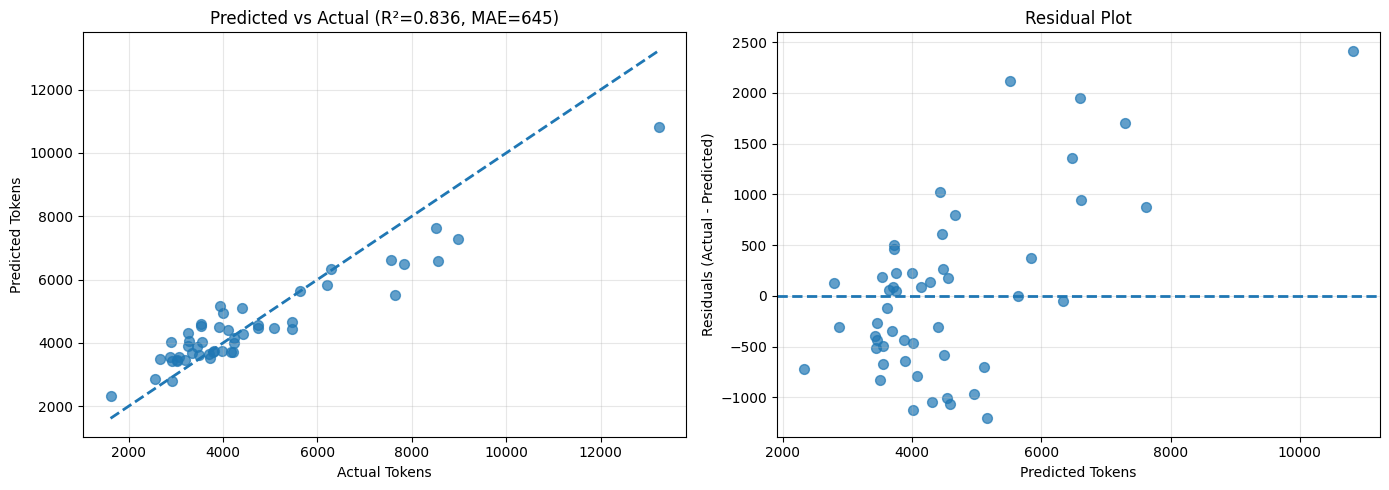


✓ Saved plot: /content/drive/MyDrive/adaptive-swe-agent/results/complexity_prediction.png

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Training on 50 samples - much better than 10
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


In [19]:
# -----------------------------------------------------------------------------
# CELL 10 (SAME FORMAT + PLOTS): Train Complexity Predictor + visualizations
# - Reads: data/task_features_real.csv
# - Saves: models/*.pkl (same filenames)
# - Prints: CV R² + training metrics + top importances (same style)
# - NEW: Adds plots (Predicted vs Actual, Residuals) + saves PNG
# -----------------------------------------------------------------------------

from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

print("="*60)
print("TRAINING COMPLEXITY PREDICTOR (50-TASK DATA, SAME FORMAT + PLOTS)")
print("="*60)

# Load features (same path as before)
df = pd.read_csv(f"{PROJECT_DIR}/data/task_features_real.csv")

feature_cols = [c for c in df.columns if c not in
                ['instance_id', 'repo', 'tokens_used', 'duration', 'patch_length']]

X = df[feature_cols].values
y = df['tokens_used'].values.astype(float)

print(f"Samples: {len(X)}, Features: {len(feature_cols)}")
print(f"Target range: {y.min():.0f} - {y.max():.0f} tokens")

# Scale features (same as before)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\n" + "="*60)
print("5-FOLD CROSS-VALIDATION")
print("="*60)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)
}

best_model = None
best_score = -np.inf
best_name = None

for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=kfold, scoring='r2', n_jobs=-1)
    print(f"{name}: R² = {scores.mean():.3f} (+/- {scores.std():.3f})")

    if scores.mean() > best_score:
        best_score = scores.mean()
        best_model = model
        best_name = name

print(f"\nBest model by CV: {best_name} (mean R²={best_score:.3f})")
print(f"Training final model: {type(best_model).__name__}")

best_model.fit(X_scaled, y)
y_pred = best_model.predict(X_scaled)

r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
mae = mean_absolute_error(y, y_pred)

print(f"R²: {r2:.3f}")
print(f"RMSE: {rmse:.1f} tokens")
print(f"MAE: {mae:.1f} tokens")

# Feature importance (same as before)
if hasattr(best_model, 'feature_importances_'):
    importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\n" + "="*60)
    print("TOP 10 FEATURES")
    print("="*60)
    print(importance.head(10).to_string(index=False))

# Save (same filenames as before)
model_dir = f"{PROJECT_DIR}/models"
os.makedirs(model_dir, exist_ok=True)

joblib.dump(best_model, f"{model_dir}/complexity_predictor.pkl")
joblib.dump(scaler, f"{model_dir}/feature_scaler.pkl")
joblib.dump(feature_cols, f"{model_dir}/feature_names.pkl")

print(f"\n✓ Models saved to {model_dir}/")

# -----------------------------
# NEW: Plots (Predicted vs Actual, Residuals)
# -----------------------------
results_dir = f"{PROJECT_DIR}/results"
os.makedirs(results_dir, exist_ok=True)

residuals = y - y_pred

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Predicted vs Actual
axes[0].scatter(y, y_pred, alpha=0.7, s=50)
axes[0].plot([y.min(), y.max()], [y.min(), y.max()], linestyle='--', linewidth=2)
axes[0].set_xlabel('Actual Tokens')
axes[0].set_ylabel('Predicted Tokens')
axes[0].set_title(f'Predicted vs Actual (R²={r2:.3f}, MAE={mae:.0f})')
axes[0].grid(True, alpha=0.3)

# Residual plot
axes[1].scatter(y_pred, residuals, alpha=0.7, s=50)
axes[1].axhline(y=0, linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Tokens')
axes[1].set_ylabel('Residuals (Actual - Predicted)')
axes[1].set_title('Residual Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()

plot_path = f"{results_dir}/complexity_prediction.png"
plt.savefig(plot_path, dpi=150)
plt.show()

print(f"\n✓ Saved plot: {plot_path}")

print("\n" + "!"*60)
print("Training on 50 samples - much better than 10")
print("!"*60)


In [20]:
# =============================================================================
# CELL 11: Test Execution System
# =============================================================================

import subprocess
import tempfile
import os

class TestExecutor:
    """Execute tests and provide feedback - KEY INNOVATION"""

    def __init__(self):
        self.test_cache = {}

    def apply_patch(self, repo_path, patch):
        """Apply patch and validate"""
        if not patch or len(patch) < 10:
            return False, "Empty or invalid patch"

        with tempfile.NamedTemporaryFile(mode='w', suffix='.patch', delete=False) as f:
            f.write(patch)
            patch_file = f.name

        try:
            # Check if patch is valid
            result = subprocess.run(
                ['git', 'apply', '--check', patch_file],
                cwd=repo_path,
                capture_output=True,
                text=True,
                timeout=10
            )

            if result.returncode == 0:
                # Apply patch
                subprocess.run(
                    ['git', 'apply', patch_file],
                    cwd=repo_path,
                    capture_output=True,
                    timeout=10
                )
                return True, "Patch applied successfully"
            else:
                return False, f"Invalid patch: {result.stderr[:200]}"

        except Exception as e:
            return False, f"Error: {str(e)[:200]}"
        finally:
            if os.path.exists(patch_file):
                os.unlink(patch_file)

    def run_tests(self, repo_path, test_cmd="pytest -xvs"):
        """Run tests and capture results"""
        try:
            result = subprocess.run(
                test_cmd.split(),
                cwd=repo_path,
                capture_output=True,
                text=True,
                timeout=60
            )

            return {
                'passed': result.returncode == 0,
                'stdout': result.stdout[-2000:],  # Last 2000 chars
                'stderr': result.stderr[-2000:],
                'returncode': result.returncode
            }

        except subprocess.TimeoutExpired:
            return {
                'passed': False,
                'stdout': '',
                'stderr': 'Test execution timed out',
                'returncode': -1
            }
        except Exception as e:
            return {
                'passed': False,
                'stdout': '',
                'stderr': str(e),
                'returncode': -1
            }

    def parse_test_feedback(self, test_result):
        """Extract actionable feedback from test failures"""
        if test_result['passed']:
            return "✓ All tests passed"

        feedback = ["✗ Tests failed:"]
        output = test_result['stdout'] + test_result['stderr']

        # Parse common failure patterns
        if 'FAILED' in output:
            failed = [line for line in output.split('\n') if 'FAILED' in line]
            feedback.append(f"  {len(failed)} test(s) failed")
            feedback.extend([f"  - {f[:80]}" for f in failed[:3]])

        if 'AssertionError' in output:
            feedback.append("  AssertionError detected")

        if 'SyntaxError' in output:
            feedback.append("  Syntax error in patch")

        if 'ImportError' in output or 'ModuleNotFoundError' in output:
            feedback.append("  Import/module error")

        return '\n'.join(feedback)

# Initialize test executor
test_executor = TestExecutor()

print("✓ Test execution system initialized")
print("  This enables test-driven solution selection")
print("  Novel contribution: Use test results to pick best solution")

✓ Test execution system initialized
  This enables test-driven solution selection
  Novel contribution: Use test results to pick best solution


In [21]:
# =============================================================================
# CELL 12 (GROUNDED): Adaptive Agent for GPT-5.1
# - Baseline-style grounding: infer ONE target file + send real file context
# - Best-of-N sampling: N from complexity predictor (or force_n)
# - Selection: pick first patch that git apply --check --recount passes
# - Fix: expm1 overflow safe handling
# - Returns: patch_applied + test_passed (alias) for Cell 13 compatibility
# =============================================================================

import os
import re
import json
import numpy as np
import joblib
import subprocess
import tempfile

print("="*60)
print("PREPARING GROUNDED ADAPTIVE AGENT (GPT-5.1)")
print("="*60)

class AdaptiveAgentGrounded:
    def __init__(self, openai_client, complexity_predictor, scaler, feature_names):
        self.client = openai_client
        self.model = "gpt-5.1"
        self.predictor = complexity_predictor
        self.scaler = scaler
        self.feature_names = feature_names

        # Load transform config (robust)
        try:
            self.transform_config = joblib.load(f"{PROJECT_DIR}/models/transform_config.pkl")
            if not isinstance(self.transform_config, dict):
                self.transform_config = {}
        except Exception:
            self.transform_config = {}

        # NOTE: this agent does apply-check (not full tests)
        # It will use git apply --check --recount as the "success" signal.

    # ---------------------------
    # Complexity prediction
    # ---------------------------
    def _use_log_transform(self) -> bool:
        return bool(
            self.transform_config.get("use_log1p", False) or
            self.transform_config.get("use_log", False) or
            self.transform_config.get("use_log_transform", False)
        )

    def predict_complexity(self, problem_statement, repo_name, all_tasks):
        metrics = extract_code_metrics(problem_statement)
        repo_feat = extract_repo_features(repo_name, all_tasks)

        feature_dict = {**metrics, **repo_feat}
        X = np.array([[feature_dict.get(f, 0) for f in self.feature_names]], dtype=float)
        X_scaled = self.scaler.transform(X)

        pred = float(self.predictor.predict(X_scaled)[0])

        if self._use_log_transform():
            # prevent overflow in expm1 if model outputs absurd values
            pred = float(np.clip(pred, -5.0, 12.0))  # expm1(12) ~ 1.6e5 (still huge)
            pred_tokens = float(np.expm1(pred))
        else:
            pred_tokens = pred

        return float(np.clip(pred_tokens, 500, 3000))
    '''
    def determine_n_samples(self, predicted_tokens):
        if predicted_tokens < 1000:
            return 1
        elif predicted_tokens < 1400:
            return 3
        elif predicted_tokens < 1800:
            return 5
        else:
            return 8
    '''

    def determine_n_samples(self, prompt_tokens: int) -> int:
        # tuned to your shown 50-task token spread
        if prompt_tokens < 3000:
            return 1
        elif prompt_tokens < 4500:
            return 3
        elif prompt_tokens < 7000:
            return 5
        else:
            return 8



    # ---------------------------
    # Target file inference (baseline-like)
    # ---------------------------
    def _is_disallowed_path(self, rel_path: str) -> bool:
        if not rel_path:
            return True
        p = rel_path.replace("\\", "/")
        if p == "CHANGES.rst":
            return True
        if p.startswith("docs/"):
            return True
        if p.startswith("doc/"):
            return True
        if "/docs/" in p:
            return True
        if p.startswith("tests/") or p.startswith("test/"):
            return True
        if "/tests/" in p or "/test/" in p:
            return True
        return False

    def _infer_target_file(self, task: dict, repo_path: str) -> str | None:
        # 1) prefer gold/oracle patch if present (but skip docs/tests/CHANGES)
        patch_text = (task.get("patch") or task.get("oracle_patch") or task.get("gold_patch") or "")
        if patch_text:
            m = re.search(r"diff --git a/(.+?) b/", patch_text)
            if m:
                cand = m.group(1).strip()
                if cand and not self._is_disallowed_path(cand):
                    if os.path.exists(os.path.join(repo_path, cand)):
                        return cand

        # 2) try path mentions in problem statement
        ps = task.get("problem_statement", "") or ""
        candidates = re.findall(r"([A-Za-z0-9_\-./]+\.(?:py|js|ts|java|go|rs|c|cpp|h|hpp))", ps)
        seen = set()
        for cand in candidates:
            cand = cand.strip()
            if cand in seen:
                continue
            seen.add(cand)
            if self._is_disallowed_path(cand):
                continue
            if os.path.exists(os.path.join(repo_path, cand)):
                return cand

        # 3) fallback search: best identifier hits in code files (skip docs/tests)
        identifiers = re.findall(r"\b[A-Za-z_][A-Za-z0-9_]{3,}\b", ps)[:12]
        stop = {"this","that","when","then","true","false","none"}
        identifiers = [w for w in identifiers if w.lower() not in stop]

        best_file, best_hits = None, 0
        for root, dirs, files in os.walk(repo_path):
            # skip heavy dirs
            if any(x in root for x in ["/.git/", "/venv/", "/.venv/", "/node_modules/", "/dist/", "/build/"]):
                continue
            # skip docs/tests dirs
            rp = root.replace("\\", "/")
            if "/docs" in rp or "/doc" in rp or "/tests" in rp or "/test" in rp:
                continue

            for fn in files:
                if not fn.endswith((".py",".js",".ts",".java",".go",".rs",".c",".cpp",".h",".hpp")):
                    continue
                fp = os.path.join(root, fn)
                rel = os.path.relpath(fp, repo_path)
                if self._is_disallowed_path(rel):
                    continue
                try:
                    with open(fp, "r", encoding="utf-8", errors="ignore") as f:
                        txt = f.read()
                    hits = sum(1 for w in identifiers if w in txt)
                    if hits > best_hits:
                        best_hits, best_file = hits, rel
                except Exception:
                    continue

        return best_file

    # ---------------------------
    # File context builder (HEAD always + keyword windows)
    # ---------------------------
    def _build_file_context(
        self,
        problem_statement: str,
        repo_path: str,
        target_file: str,
        head_lines: int = 200,
        window_before: int = 140,
        window_after: int = 220,
        max_context_chars: int = 32000,
        max_windows: int = 6,
    ) -> str:
        abs_path = os.path.join(repo_path, target_file)
        if not os.path.exists(abs_path):
            return f"Target file not found: {target_file}"

        with open(abs_path, "r", encoding="utf-8", errors="ignore") as f:
            lines = f.readlines()

        ps = problem_statement or ""
        identifiers = re.findall(r"\b[A-Za-z_][A-Za-z0-9_]{3,}\b", ps)[:14]
        stop = {"this","that","when","then","true","false","none"}
        identifiers = [w for w in identifiers if w.lower() not in stop]

        hit_idxs = [i for i, ln in enumerate(lines) if any(w in ln for w in identifiers)]
        hit_idxs = hit_idxs[:max_windows]

        def clamp(v, lo, hi): return max(lo, min(hi, v))

        chunks = []
        # Always include HEAD
        chunks.append((0, min(len(lines), head_lines)))

        # Include windows around hits
        for idx in hit_idxs:
            s = clamp(idx - window_before, 0, len(lines))
            e = clamp(idx + window_after, 0, len(lines))
            chunks.append((s, e))

        # Merge overlapping chunks
        chunks.sort()
        merged = []
        for s, e in chunks:
            if not merged or s > merged[-1][1]:
                merged.append([s, e])
            else:
                merged[-1][1] = max(merged[-1][1], e)

        # Render with soft char cap
        out = [f"FILE: {target_file}\n"]
        total = len(out[0])

        for s, e in merged:
            header = f"\n----- LINES {s+1}-{e} -----\n"
            block = header + "".join(lines[s:e])
            if total + len(block) > max_context_chars:
                # truncate block to fit
                remaining = max(0, max_context_chars - total)
                if remaining <= len(header) + 50:
                    break
                block = header + ("".join(lines[s:e]))[:(remaining - len(header))]
            out.append(block)
            total += len(block)
            if total >= max_context_chars:
                break

        return "".join(out)

    # ---------------------------
    # Patch extraction + validation
    # ---------------------------
    def _extract_patch(self, text: str) -> str:
        if not text:
            return ""
        # strip markdown fences
        text = re.sub(r"^\s*```(?:diff)?\s*\n", "", text, flags=re.MULTILINE)
        text = re.sub(r"\n\s*```\s*$", "", text, flags=re.MULTILINE)

        m = re.search(r"(?m)^diff --git ", text)
        if not m:
            return ""
        patch = text[m.start():].replace("\r\n", "\n").replace("\r", "\n").strip("\n") + "\n"
        return patch

    def _patch_file_count(self, patch: str) -> int:
        return patch.count("diff --git")

    def _extract_patch_files(self, patch: str):
        files = []
        for ln in patch.splitlines():
            if ln.startswith("diff --git"):
                m = re.search(r"diff --git a/(.+?) b/", ln)
                if m:
                    files.append(m.group(1))
        return files

    def _git_apply_check(self, repo_path: str, patch: str) -> tuple[bool, str]:
        if not patch.strip():
            return False, "Empty patch"

        with tempfile.NamedTemporaryFile(mode="w", suffix=".patch", delete=False, encoding="utf-8") as f:
            f.write(patch)
            tmp = f.name

        try:
            cmd = ["git", "apply", "--check", "--verbose", "--recount", tmp]
            p = subprocess.run(cmd, cwd=repo_path, capture_output=True, text=True)
            ok = (p.returncode == 0)
            msg = (p.stderr or p.stdout or "").strip()
            return ok, msg
        finally:
            try:
                os.unlink(tmp)
            except Exception:
                pass

    # ---------------------------
    # One grounded LLM call (for ONE target file)
    # ---------------------------
    def generate_solution_for_target(
        self,
        problem_statement: str,
        target_file: str,
        file_context: str,
        max_completion_tokens: int = 4096,
        temperature: float = 0.7,
        strategy_hint: str | None = None,
    ) -> tuple[str, int]:
        strict = (
            f"STRICT RULES:\n"
            f"- You MUST ONLY modify this one file: {target_file}\n"
            f"- Do NOT modify tests, docs, CHANGES.rst.\n"
            f"- Use EXACT context lines from the provided file snippets.\n"
        )

        system = (
            "You are an expert software engineer. "
            "Return ONLY a valid unified diff patch. No markdown, no commentary."
        )

        user = (
            f"Fix the bug described below.\n\n"
            f"PROBLEM:\n{problem_statement}\n\n"
            + (f"STRATEGY HINT:\n{strategy_hint}\n\n" if strategy_hint else "")
            + f"TARGET FILE: {target_file}\n\n"
            + strict + "\n"
            + "FILE CONTEXT (ground truth snippets from pinned commit):\n"
            + file_context + "\n\n"
            + "OUTPUT REQUIREMENTS:\n"
            + "- Output ONLY a unified diff starting with 'diff --git'.\n"
            + "- Modify exactly one file (the target file).\n"
            + "- Include correct @@ hunk headers.\n"
            + "- Reuse EXACT context lines from the snippets.\n"
        )

        resp = self.client.chat.completions.create(
            model=self.model,
            messages=[{"role": "system", "content": system},
                      {"role": "user", "content": user}],
            max_completion_tokens=max_completion_tokens,
            temperature=temperature,
        )
        txt = resp.choices[0].message.content or ""
        tokens = resp.usage.total_tokens if getattr(resp, "usage", None) else 0
        patch = self._extract_patch(txt)
        return patch, tokens

    # ---------------------------
    # Main solve: adaptive best-of-N (or force_n)
    # ---------------------------
    def solve_with_feedback(self, task: dict, repo_path: str, all_tasks: list, force_n: int | None = None, stop_early: bool = True):
        problem_statement = task.get("problem_statement") or ""
        repo_name = task.get("repo") or ""

        target_file = self._infer_target_file(task, repo_path)
        if not target_file:
            return {
                "patch": "",
                "tokens_used": 0,
                "n_samples": 0,
                "attempts_made": 0,
                "first_apply_index": None,
                "predicted_tokens": None,
                "patch_applied": False,
                "test_passed": False,
                "success": False,
                "target_file": None,
                "apply_stderr": "Could not infer target file",
            }

        file_context = self._build_file_context(problem_statement, repo_path, target_file)

        predicted = self.predict_complexity(problem_statement, repo_name, all_tasks)
        n = int(force_n) if force_n is not None else int(self.determine_n_samples(predicted))

        print(f"  target_file: {target_file}")
        print(
            f"  Predicted: {predicted:.0f} tokens → N={n}"
            + (f" (forced)" if force_n is not None else "")
            + ("" if stop_early else " (no-early-stop)")
        )

        strategy_bank = [
            "Trace the expected behavior from docs/comments and implement the minimal fix.",
            "Look for edge-case handling (None, empty, off-by-one) and patch minimally.",
            "Search for the function mentioned in the problem; fix logic without refactoring.",
            "Focus on correctness first; keep diff minimal and local.",
        ]

        total_tokens = 0
        attempts_made = 0

        best_patch = None
        best_apply_msg = ""
        first_apply_index = None

        for i in range(n):
            # diversity: temps + optional strategy hints for larger N
            if n >= 8:
                hint = strategy_bank[i % len(strategy_bank)]
                temp = 0.2 if i == 0 else (0.6 if i % 2 == 0 else 0.85)
            else:
                hint = None
                temp = 0.3 if i == 0 else 0.7

            patch, toks = self.generate_solution_for_target(
                problem_statement=problem_statement,
                target_file=target_file,
                file_context=file_context,
                max_completion_tokens=4096,
                temperature=temp,
                strategy_hint=hint,
            )

            total_tokens += toks
            attempts_made += 1

            # enforce single-file diff
            if not patch:
                continue
            if self._patch_file_count(patch) != 1:
                continue
            files = self._extract_patch_files(patch)
            if not files or files[0] != target_file:
                continue

            ok, msg = self._git_apply_check(repo_path, patch)

            if ok:
                # keep the first apply-able patch
                if best_patch is None:
                    best_patch = patch
                    best_apply_msg = msg
                    first_apply_index = i
                    print("    ✓ Patch applies cleanly")

                # Adaptive: stop early; Fixed: keep going if stop_early=False
                if stop_early:
                    break
            else:
                best_apply_msg = msg  # keep last error for debugging

        patch_applied = bool(best_patch)
        return {
            "patch": best_patch or "",
            "tokens_used": total_tokens,
            "n_samples": n,
            "attempts_made": attempts_made,
            "first_apply_index": first_apply_index,
            "predicted_tokens": predicted,
            "patch_applied": patch_applied,
            "test_passed": patch_applied,   # alias for your older Cell 13
            "success": patch_applied,       # compatibility
            "target_file": target_file,
            "apply_stderr": best_apply_msg[:800],
        }


print("\n" + "="*60)
print("LOADING GROUNDED ADAPTIVE AGENT")
print("="*60)

complexity_model = joblib.load(f"{PROJECT_DIR}/models/complexity_predictor.pkl")
feature_scaler = joblib.load(f"{PROJECT_DIR}/models/feature_scaler.pkl")
feature_names = joblib.load(f"{PROJECT_DIR}/models/feature_names.pkl")

adaptive_agent = AdaptiveAgentGrounded(
    client,
    complexity_model,
    feature_scaler,
    feature_names
)

print("✓ Grounded adaptive agent ready")

PREPARING GROUNDED ADAPTIVE AGENT (GPT-5.1)

LOADING GROUNDED ADAPTIVE AGENT
✓ Grounded adaptive agent ready


In [22]:
# =============================================================================
# CELL 12.5: Fixed Best-of-10 Agent (GROUNDED)
# - Reuses adaptive_agent.solve_with_feedback(..., force_n=10)
# - IMPORTANT: stop_early=False so it ALWAYS runs all 10 attempts
# =============================================================================

class FixedBestOf10Agent:
    def __init__(self, grounded_agent, n: int = 10):
        self.base = grounded_agent
        self.n = int(n)

    def solve_fixed_10(self, task: dict, repo_path: str, all_tasks: list):
        return self.base.solve_with_feedback(
            task, repo_path, all_tasks,
            force_n=self.n,
            stop_early=False
        )

fixed10_agent = FixedBestOf10Agent(adaptive_agent, n=10)
print("✓ Fixed Best-of-10 agent ready (grounded, no early stop)")

✓ Fixed Best-of-10 agent ready (grounded, no early stop)


In [23]:
# =============================================================================
# CELL 13: Baseline vs Adaptive vs Fixed-10 Comparison (APPLY-CHECK)
# =============================================================================

import time
import pandas as pd
import json

print("="*60)
print("BASELINE vs ADAPTIVE vs FIXED-10 EVALUATION")
print("="*60)

with open(f"{PROJECT_DIR}/data/swebench_subset_50.jsonl") as f:
    all_test_tasks = [json.loads(line) for line in f]

with open(f"{PROJECT_DIR}/data/swebench_lite.jsonl") as f:
    all_tasks = [json.loads(line) for line in f]

test_tasks = all_test_tasks[:5]
print(f"Running on {len(test_tasks)} tasks")
print("="*60 + "\n")

rows = []

for i, task in enumerate(test_tasks):
    print(f"\n[{i+1}/{len(test_tasks)}] {task['instance_id']}")
    print(f"Repo: {task['repo']}")

    repo_path = repo_mgr.setup_repository(task['repo'], task['base_commit'])
    if not repo_path:
        print("  ✗ Repo setup failed")
        continue

    try:
        # -------------------
        # Baseline (your N=1 agent)
        # -------------------
        t0 = time.time()
        base_res = agent.solve_issue(task, repo_path)
        base_time = time.time() - t0

        # Optional: apply-check baseline patch for apples-to-apples
        base_applied = False
        base_apply_msg = ""
        if base_res.get("patch"):
            ok, msg = adaptive_agent._git_apply_check(repo_path, base_res["patch"])
            base_applied = ok
            base_apply_msg = msg[:400]

        subprocess.run(['git', 'reset', '--hard'], cwd=repo_path, capture_output=True, text=True)
        subprocess.run(['git', 'clean', '-fd'], cwd=repo_path, capture_output=True, text=True)

        # -------------------
        # Adaptive (grounded)
        # -------------------
        t1 = time.time()
        adap_res = adaptive_agent.solve_with_feedback(task, repo_path, all_tasks)
        adap_time = time.time() - t1

        subprocess.run(['git', 'reset', '--hard'], cwd=repo_path, capture_output=True, text=True)
        subprocess.run(['git', 'clean', '-fd'], cwd=repo_path, capture_output=True, text=True)

        # -------------------
        # Fixed-10 (grounded)
        # -------------------
        t2 = time.time()
        fixed_res = fixed10_agent.solve_fixed_10(task, repo_path, all_tasks)
        fixed_time = time.time() - t2

        # record
        rows.append({
            "instance_id": task["instance_id"],
            "repo": task["repo"],

            "baseline_tokens": base_res.get("tokens_used", 0),
            "baseline_time": base_time,
            "baseline_has_patch": bool(base_res.get("patch")),
            "baseline_patch_applied": base_applied,
            "baseline_patch_len": len(base_res.get("patch") or ""),
            "baseline_patch": base_res.get("patch") or "",
            "baseline_apply_stderr": base_apply_msg,

            "adaptive_tokens": adap_res.get("tokens_used", 0),
            "adaptive_time": adap_time,
            "adaptive_n": adap_res.get("n_samples", 0),
            "adaptive_predicted_tokens": adap_res.get("predicted_tokens", None),
            "adaptive_has_patch": bool(adap_res.get("patch")),
            "adaptive_patch_applied": bool(adap_res.get("patch_applied")),
            "adaptive_patch_len": len(adap_res.get("patch") or ""),
            "adaptive_patch": adap_res.get("patch") or "",
            "adaptive_target_file": adap_res.get("target_file"),
            "adaptive_apply_stderr": (adap_res.get("apply_stderr") or "")[:400],

            "fixed10_tokens": fixed_res.get("tokens_used", 0),
            "fixed10_time": fixed_time,
            "fixed10_n": fixed_res.get("n_samples", 10),
            "fixed10_has_patch": bool(fixed_res.get("patch")),
            "fixed10_patch_applied": bool(fixed_res.get("patch_applied")),
            "fixed10_patch_len": len(fixed_res.get("patch") or ""),
            "fixed10_patch": fixed_res.get("patch") or "",
            "fixed10_target_file": fixed_res.get("target_file"),
            "fixed10_apply_stderr": (fixed_res.get("apply_stderr") or "")[:400],
        })

        print(f"  Baseline: tokens={base_res.get('tokens_used',0)} applied={base_applied}")
        print(f"  Adaptive: N={adap_res.get('n_samples')} tokens={adap_res.get('tokens_used',0)} applied={adap_res.get('patch_applied',False)}")
        print(f"  Fixed-10: N=10 tokens={fixed_res.get('tokens_used',0)} applied={fixed_res.get('patch_applied',False)}")

    finally:
        repo_mgr.cleanup_repository(repo_path)

df = pd.DataFrame(rows)
out_csv = f"{PROJECT_DIR}/results/baseline_vs_adaptive_vs_fixed10_5.csv"
df.to_csv(out_csv, index=False)

print("\n" + "="*60)
print("SUMMARY (APPLY-CHECK)")
print("="*60)
if len(df):
    print("Apply rate:")
    print(f"  Baseline: {df['baseline_patch_applied'].mean():.1%}")
    print(f"  Adaptive: {df['adaptive_patch_applied'].mean():.1%}")
    print(f"  Fixed-10: {df['fixed10_patch_applied'].mean():.1%}")
    print("\nAvg tokens:")
    print(f"  Baseline: {df['baseline_tokens'].mean():.0f}")
    print(f"  Adaptive: {df['adaptive_tokens'].mean():.0f}")
    print(f"  Fixed-10: {df['fixed10_tokens'].mean():.0f}")

print(f"\n✓ Saved: {out_csv}")

BASELINE vs ADAPTIVE vs FIXED-10 EVALUATION
Running on 5 tasks


[1/5] django__django-15213
Repo: django/django
  Cloning django/django ...
  ✓ Ready at commit 03cadb91
  target_file: django/db/models/fields/__init__.py
  Predicted: 3000 tokens → N=3
    ✓ Patch applies cleanly
  target_file: django/db/models/fields/__init__.py
  Predicted: 3000 tokens → N=10 (forced) (no-early-stop)
    ✓ Patch applies cleanly
  Baseline: tokens=7563 applied=True
  Adaptive: N=3 tokens=7104 applied=True
  Fixed-10: N=10 tokens=71803 applied=True

[2/5] django__django-11630
Repo: django/django
  Cloning django/django ...
  ✓ Ready at commit 65e86948
  target_file: django/core/checks/model_checks.py
  Predicted: 3000 tokens → N=3
    ✓ Patch applies cleanly
  target_file: django/core/checks/model_checks.py
  Predicted: 3000 tokens → N=10 (forced) (no-early-stop)
    ✓ Patch applies cleanly
  Baseline: tokens=3269 applied=False
  Adaptive: N=3 tokens=2770 applied=True
  Fixed-10: N=10 tokens=24477 applie

In [24]:
# =============================================================================
# CELL 14: Export Prediction JSONLs (Baseline + Adaptive + Fixed-10) from Cell 13 CSV
# - Reads: results/baseline_vs_adaptive_vs_fixed10_5.csv
# - Writes:
#   predictions/baseline_subset_5_from_comparison.jsonl
#   predictions/adaptive_subset_5.jsonl
#   predictions/fixed10_subset_5.jsonl
# =============================================================================

import os
import json
import pandas as pd
import numpy as np

comparison_csv = f"{PROJECT_DIR}/results/baseline_vs_adaptive_vs_fixed10_5.csv"
assert os.path.exists(comparison_csv), f"Missing: {comparison_csv} (run Cell 13 first)"

df = pd.read_csv(comparison_csv)
print(f"Loaded: {comparison_csv} ({len(df)} rows)")

os.makedirs(f"{PROJECT_DIR}/predictions", exist_ok=True)

def _safe_patch(val) -> str:
    if val is None:
        return ""
    if isinstance(val, float) and np.isnan(val):
        return ""
    s = str(val)
    return s if s.lower() != "nan" else ""

def export_jsonl(out_path: str, patch_col: str, model_name: str):
    with open(out_path, "w") as f:
        for _, row in df.iterrows():
            patch = _safe_patch(row.get(patch_col, ""))
            obj = {
                "instance_id": row["instance_id"],
                "model_patch": patch,
                "model_name_or_path": model_name,
            }
            f.write(json.dumps(obj) + "\n")
    print(f"✓ Wrote: {out_path} (patch_col={patch_col})")

baseline_out = f"{PROJECT_DIR}/predictions/baseline_subset_5_from_comparison.jsonl"
adaptive_out = f"{PROJECT_DIR}/predictions/adaptive_subset_5.jsonl"
fixed10_out  = f"{PROJECT_DIR}/predictions/fixed10_subset_5.jsonl"

export_jsonl(baseline_out, "baseline_patch", "baseline_gpt5_1_grounded")
export_jsonl(adaptive_out, "adaptive_patch", "adaptive_gpt5_1_bestofN")
export_jsonl(fixed10_out,  "fixed10_patch",  "fixed10_gpt5_1_bestof10")

print("\n✓ Export complete.")
print("  Format: {instance_id, model_patch, model_name_or_path}")

Loaded: /content/drive/MyDrive/adaptive-swe-agent/results/baseline_vs_adaptive_vs_fixed10_5.csv (5 rows)
✓ Wrote: /content/drive/MyDrive/adaptive-swe-agent/predictions/baseline_subset_5_from_comparison.jsonl (patch_col=baseline_patch)
✓ Wrote: /content/drive/MyDrive/adaptive-swe-agent/predictions/adaptive_subset_5.jsonl (patch_col=adaptive_patch)
✓ Wrote: /content/drive/MyDrive/adaptive-swe-agent/predictions/fixed10_subset_5.jsonl (patch_col=fixed10_patch)

✓ Export complete.
  Format: {instance_id, model_patch, model_name_or_path}


In [25]:
# =============================================================================
# CELL 14.1: Quick Sanity Check JSONL (preview)
# =============================================================================

import json

preview_path = f"{PROJECT_DIR}/predictions/adaptive_subset_5.jsonl"  # change if you want
assert os.path.exists(preview_path), f"Missing: {preview_path}"

with open(preview_path) as f:
    first = json.loads(next(f))

print("instance_id:", first.get("instance_id"))
print("model_name_or_path:", first.get("model_name_or_path"))
print("\nPatch preview:\n")
print((first.get("model_patch") or "")[:800])


instance_id: django__django-15213
model_name_or_path: adaptive_gpt5_1_bestofN

Patch preview:

diff --git a/django/db/models/fields/__init__.py b/django/db/models/fields/__init__.py
index 4f8a3f1..7b9a4d2 100644
--- a/django/db/models/fields/__init__.py
+++ b/django/db/models/fields/__init__.py
@@ -612,7 +612,10 @@ class Field(RegisterLookupMixin):
 
     def get_prep_value(self, value):
         """Perform preliminary non-db specific value checks and conversions."""
-        if isinstance(value, Promise):
+        if hasattr(value, 'resolve_expression'):
+            # Resolve expressions (e.g. Q objects wrapped in ExpressionWrapper)
+            # to allow proper boolean casting and SQL generation.
+            value = value.resolve_expression(connection)
+        if isinstance(value, Promise):
             value = value._proxy____cast()
         return value



In [26]:
# =============================================================================
# CELL 15: Examine Generated Patches (Baseline/Adaptive/Fixed-10)
# - Reads a selected JSONL and prints basic patch quality checks.
# =============================================================================

import json
import os

PRED_PATH = f"{PROJECT_DIR}/predictions/adaptive_subset_5.jsonl"  # <- change to fixed10 or baseline
assert os.path.exists(PRED_PATH), f"Missing: {PRED_PATH}"

print("="*60)
print(f"EXAMINING PATCHES: {PRED_PATH}")
print("="*60)

with open(PRED_PATH) as f:
    preds = [json.loads(line) for line in f]

for i, pred in enumerate(preds[:10]):
    patch = pred.get("model_patch", "") or ""
    iid = pred.get("instance_id")

    print(f"\n{'='*60}")
    print(f"[{i+1}/{min(len(preds),10)}] {iid}")
    print(f"{'='*60}")
    print(f"Patch length: {len(patch)} chars")

    print("\nFirst 500 chars:")
    print(patch[:500])
    print("\n... (truncated)")

    issues = []
    if not patch:
        issues.append("❌ Empty patch")
    else:
        if not patch.startswith("diff --git"):
            issues.append("❌ Doesn't start with 'diff --git'")
        if "@@" not in patch:
            issues.append("❌ Missing hunk headers (@@)")
        # Ensure there are actual +/- changes excluding file headers
        has_changes = any(
            ln.startswith(("+", "-")) and not ln.startswith(("+++", "---"))
            for ln in patch.splitlines()
        )
        if not has_changes:
            issues.append("❌ No actual change lines (+/-)")

    if issues:
        print("\n⚠️ PATCH ISSUES:")
        for issue in issues:
            print(" ", issue)
    else:
        print("\n✓ Patch looks like a valid unified diff (format-wise)")


EXAMINING PATCHES: /content/drive/MyDrive/adaptive-swe-agent/predictions/adaptive_subset_5.jsonl

[1/5] django__django-15213
Patch length: 779 chars

First 500 chars:
diff --git a/django/db/models/fields/__init__.py b/django/db/models/fields/__init__.py
index 4f8a3f1..7b9a4d2 100644
--- a/django/db/models/fields/__init__.py
+++ b/django/db/models/fields/__init__.py
@@ -612,7 +612,10 @@ class Field(RegisterLookupMixin):
 
     def get_prep_value(self, value):
         """Perform preliminary non-db specific value checks and conversions."""
-        if isinstance(value, Promise):
+        if hasattr(value, 'resolve_expression'):
+            # Resolve expression

... (truncated)

✓ Patch looks like a valid unified diff (format-wise)

[2/5] django__django-11630
Patch length: 3270 chars

First 500 chars:
diff --git a/django/core/checks/model_checks.py b/django/core/checks/model_checks.py
index 1111111..2222222 100644
--- a/django/core/checks/model_checks.py
+++ b/django/core/checks/model_ch

In [27]:
# =============================================================================
# CELL 16: Patch Validation Report (format-only)
# - Validates that each patch looks like a unified diff.
# =============================================================================

import json
import os

PRED_PATH = f"{PROJECT_DIR}/predictions/adaptive_subset_5.jsonl"  # <- switch if desired
assert os.path.exists(PRED_PATH), f"Missing: {PRED_PATH}"

def validate_unified_diff(patch: str):
    if not patch or len(patch) < 10:
        return False, "Empty or too short"

    lines = patch.splitlines()

    # diff header should be at top for SWE-bench harness style
    if not lines[0].startswith("diff --git"):
        return False, "Missing 'diff --git' as first line"

    has_file_headers = any(l.startswith("--- ") for l in lines) and any(l.startswith("+++ ") for l in lines)
    if not has_file_headers:
        return False, "Missing file headers (--- and +++)"

    has_hunks = any(l.startswith("@@") for l in lines)
    if not has_hunks:
        return False, "Missing hunk headers (@@)"

    has_changes = any(
        (l.startswith("+") or l.startswith("-")) and not l.startswith(("+++", "---"))
        for l in lines
    )
    if not has_changes:
        return False, "No actual changes (+/- lines)"

    return True, "Valid"

print("="*60)
print(f"PATCH VALIDATION REPORT (FORMAT ONLY): {PRED_PATH}")
print("="*60)

with open(PRED_PATH) as f:
    preds = [json.loads(line) for line in f]

valid_count = 0
for pred in preds:
    patch = pred.get("model_patch", "") or ""
    iid = pred.get("instance_id", "UNKNOWN")
    ok, reason = validate_unified_diff(patch)
    print(f"\n{'✓' if ok else '✗'} {iid}")
    print(f"  {reason}")
    if ok:
        valid_count += 1
    else:
        first_line = patch.splitlines()[0] if patch else ""
        print(f"  Length: {len(patch)} chars")
        print(f"  First line: {first_line[:120]}")

print(f"\n{'='*60}")
print(f"Valid patches: {valid_count}/{len(preds)}")
print(f"{'='*60}")


PATCH VALIDATION REPORT (FORMAT ONLY): /content/drive/MyDrive/adaptive-swe-agent/predictions/adaptive_subset_5.jsonl

✓ django__django-15213
  Valid

✓ django__django-11630
  Valid

✓ django__django-11019
  Valid

✓ django__django-15819
  Valid

✓ django__django-12747
  Valid

Valid patches: 5/5


In [28]:
# =============================================================================
# CELL 17: Deep Patch Apply Analysis (uses repo_mgr, aligned with your pipeline)
# - Analyzes WHY a patch fails to apply via git apply --check --verbose --recount
# =============================================================================

import json
import subprocess
import tempfile
import os
from pathlib import Path

PRED_PATH = f"{PROJECT_DIR}/predictions/adaptive_subset_5.jsonl"  # <- choose adaptive/fixed10/baseline
TASKS_PATH = f"{PROJECT_DIR}/data/swebench_subset_50.jsonl"       # contains the tasks
N_ANALYZE = 2                                                     # analyze first N failures in detail

assert os.path.exists(PRED_PATH), f"Missing: {PRED_PATH}"
assert os.path.exists(TASKS_PATH), f"Missing: {TASKS_PATH}"

with open(PRED_PATH) as f:
    preds = [json.loads(line) for line in f]

with open(TASKS_PATH) as f:
    tasks = [json.loads(line) for line in f]

task_lookup = {t["instance_id"]: t for t in tasks}

def git_apply_check_verbose(repo_path: str, patch: str):
    with tempfile.NamedTemporaryFile(mode="w", suffix=".patch", delete=False, encoding="utf-8") as f:
        f.write(patch)
        patch_file = f.name
    try:
        cmd = ["git", "apply", "--check", "--verbose", "--recount", patch_file]
        res = subprocess.run(cmd, cwd=repo_path, capture_output=True, text=True)
        return res.returncode == 0, res.stdout, res.stderr
    finally:
        if os.path.exists(patch_file):
            os.unlink(patch_file)

def extract_target_file(patch: str):
    import re
    m = re.search(r"diff --git a/(.+?) b/", patch or "")
    return m.group(1).strip() if m else None

failures_analyzed = 0

print("="*60)
print("DEEP PATCH APPLY ANALYSIS")
print("="*60)
print(f"Predictions: {PRED_PATH}")
print("="*60)

for pred in preds:
    iid = pred["instance_id"]
    patch = pred.get("model_patch", "") or ""
    task = task_lookup.get(iid)
    if task is None:
        print(f"\n{iid}: ⚠ Task not found in {TASKS_PATH}, skipping")
        continue

    if not patch.strip():
        print(f"\n{iid}: ✗ Empty patch (skip)")
        continue

    repo_path = repo_mgr.setup_repository(task["repo"], task["base_commit"])
    if not repo_path:
        print(f"\n{iid}: ✗ Repo setup failed")
        continue

    ok, out, err = git_apply_check_verbose(repo_path, patch)
    target = extract_target_file(patch)

    print(f"\n{iid}: {'✓ APPLIES' if ok else '✗ DOES NOT APPLY'}")
    print(f"  Repo: {task['repo']}")
    print(f"  Target file: {target}")

    if not ok:
        print("\n  --- git apply stderr (first 800 chars) ---")
        print((err or "")[:800])

        # If file exists, show some quick context around first failure hunk header if possible
        if target:
            abs_path = os.path.join(repo_path, target)
            if os.path.exists(abs_path):
                try:
                    with open(abs_path, "r", encoding="utf-8", errors="replace") as f:
                        lines = f.readlines()
                    print(f"\n  File exists: ✓ ({len(lines)} lines)")
                    print(f"  First line: {lines[0].rstrip()[:120] if lines else '(empty)'}")
                except Exception as e:
                    print(f"\n  Could not read target file for context: {e}")
            else:
                print("\n  File exists: ✗ (path not found on disk)")

        failures_analyzed += 1

    repo_mgr.cleanup_repository(repo_path)

    if failures_analyzed >= N_ANALYZE:
        break

print("\n✓ Deep analysis done.")


DEEP PATCH APPLY ANALYSIS
Predictions: /content/drive/MyDrive/adaptive-swe-agent/predictions/adaptive_subset_5.jsonl
  Cloning django/django ...
  ✓ Ready at commit 03cadb91

django__django-15213: ✓ APPLIES
  Repo: django/django
  Target file: django/db/models/fields/__init__.py
  Cloning django/django ...
  ✓ Ready at commit 65e86948

django__django-11630: ✓ APPLIES
  Repo: django/django
  Target file: django/core/checks/model_checks.py
  Cloning django/django ...
  ✓ Ready at commit 93e892bb

django__django-11019: ✓ APPLIES
  Repo: django/django
  Target file: django/forms/widgets.py
  Cloning django/django ...
  ✓ Ready at commit 877c800f

django__django-15819: ✓ APPLIES
  Repo: django/django
  Target file: django/core/management/commands/inspectdb.py
  Cloning django/django ...
  ✓ Ready at commit c86201b6

django__django-12747: ✓ APPLIES
  Repo: django/django
  Target file: django/db/models/deletion.py

✓ Deep analysis done.


In [29]:
# =============================================================================
# CELL 18 (ROBUST): Comprehensive Evaluation (Baseline vs Adaptive vs Fixed-10)
# - Reads: results/baseline_vs_adaptive_vs_fixed10_5.csv
# - Saves: evaluation/comprehensive_results.json
# - Robust to column-name differences (no KeyError)
# =============================================================================

import os
import json
import pandas as pd
import numpy as np

comparison_csv = f"{PROJECT_DIR}/results/baseline_vs_adaptive_vs_fixed10_5.csv"
assert os.path.exists(comparison_csv), f"Missing: {comparison_csv} (run Cell 13 first)"

df = pd.read_csv(comparison_csv)

print("="*60)
print("COMPREHENSIVE EVALUATION (ROBUST)")
print("="*60)
print(f"Loaded: {comparison_csv} ({len(df)} rows)")
print("\nColumns in CSV:")
print(list(df.columns))

def pick_col(candidates, required=True):
    """Pick the first existing column from candidates."""
    for c in candidates:
        if c in df.columns:
            return c
    if required:
        raise KeyError(f"None of these columns exist: {candidates}\nAvailable: {list(df.columns)}")
    return None

def to_bool_series(col):
    if col is None:
        return pd.Series([np.nan] * len(df))
    s = df[col]
    # Handles True/False, 0/1, "true"/"false"
    if s.dtype == bool:
        return s.astype(float)
    if np.issubdtype(s.dtype, np.number):
        return (s != 0).astype(float)
    return s.astype(str).str.lower().isin(["true", "1", "yes", "y"]).astype(float)

def patch_rate(col):
    if col is None:
        return float("nan")
    return float((df[col].fillna("").astype(str).str.len() > 0).mean())

# ---- Try to map your actual column names ----
# Tokens
baseline_tokens_col = pick_col(["baseline_tokens", "baseline_tokens_used", "baseline_total_tokens", "baseline_tok"])
adaptive_tokens_col = pick_col(["adaptive_tokens", "adaptive_tokens_used", "adaptive_total_tokens", "adaptive_tok"])
fixed10_tokens_col  = pick_col(["fixed10_tokens", "fixed_10_tokens", "fixed_tokens", "fixed10_tokens_used"])

# Duration
baseline_dur_col = pick_col(["baseline_duration", "baseline_duration_s", "baseline_time", "baseline_time_s", "baseline_seconds"], required=False)
adaptive_dur_col = pick_col(["adaptive_duration", "adaptive_duration_s", "adaptive_time", "adaptive_time_s", "adaptive_seconds"], required=False)
fixed10_dur_col  = pick_col(["fixed10_duration", "fixed_10_duration", "fixed10_duration_s", "fixed10_time", "fixed10_time_s"], required=False)

# Patch applied / apply success
baseline_applied_col = pick_col(["baseline_patch_applied", "baseline_applied", "baseline_apply_ok", "baseline_success"], required=False)
adaptive_applied_col = pick_col(["adaptive_patch_applied", "adaptive_applied", "adaptive_apply_ok", "adaptive_success"], required=False)
fixed10_applied_col  = pick_col(["fixed10_patch_applied", "fixed10_applied", "fixed10_apply_ok", "fixed10_success"], required=False)

# Patch text
baseline_patch_col = pick_col(["baseline_patch", "baseline_model_patch", "baseline_patch_text"], required=False)
adaptive_patch_col = pick_col(["adaptive_patch", "adaptive_model_patch", "model_patch", "adaptive_patch_text"], required=False)
fixed10_patch_col  = pick_col(["fixed10_patch", "fixed_10_patch", "fixed10_model_patch", "fixed10_patch_text"], required=False)

# N samples + predicted tokens (optional)
adaptive_n_col = pick_col(["adaptive_n_samples", "n_samples", "adaptive_n"], required=False)
predicted_col  = pick_col(["predicted_tokens", "adaptive_predicted_tokens", "pred_tokens"], required=False)

def summarize(name, tok_col, dur_col, applied_col, patch_col):
    out = {
        "avg_tokens": float(df[tok_col].mean()),
        "avg_duration": float(df[dur_col].mean()) if dur_col else float("nan"),
        "apply_rate": float(to_bool_series(applied_col).mean()) if applied_col else float("nan"),
        "patch_rate": patch_rate(patch_col),
        "cols_used": {
            "tokens": tok_col,
            "duration": dur_col,
            "applied": applied_col,
            "patch": patch_col,
        }
    }
    return out

baseline = summarize("baseline", baseline_tokens_col, baseline_dur_col, baseline_applied_col, baseline_patch_col)
adaptive = summarize("adaptive", adaptive_tokens_col, adaptive_dur_col, adaptive_applied_col, adaptive_patch_col)
fixed10  = summarize("fixed10",  fixed10_tokens_col,  fixed10_dur_col,  fixed10_applied_col,  fixed10_patch_col)

print("\n" + "="*60)
print("METRIC 1: COMPUTE")
print("="*60)
print("Baseline:", baseline)
print("Adaptive:", adaptive)
print("Fixed-10:", fixed10)

print("\n" + "="*60)
print("METRIC 2: APPLY SUCCESS (proxy quality)")
print("="*60)
if not np.isnan(baseline["apply_rate"]):
    print(f"Baseline apply_rate: {baseline['apply_rate']*100:.1f}%")
else:
    print("Baseline apply_rate: (no applied column found)")
if not np.isnan(adaptive["apply_rate"]):
    print(f"Adaptive apply_rate: {adaptive['apply_rate']*100:.1f}%")
else:
    print("Adaptive apply_rate: (no applied column found)")
if not np.isnan(fixed10["apply_rate"]):
    print(f"Fixed-10 apply_rate: {fixed10['apply_rate']*100:.1f}%")
else:
    print("Fixed-10 apply_rate: (no applied column found)")

print("\n" + "="*60)
print("PER-TASK BREAKDOWN")
print("="*60)

for _, r in df.iterrows():
    iid = r.get("instance_id", "(no instance_id)")
    repo = r.get("repo", "(no repo)")
    print(f"\n{iid} ({repo}):")
    print(f"  Baseline: tokens={float(r[baseline_tokens_col]):.0f}"
          + (f" duration={float(r[baseline_dur_col]):.1f}s" if baseline_dur_col else "")
          + (f" applied={bool(r[baseline_applied_col])}" if baseline_applied_col else ""))
    print(f"  Adaptive: tokens={float(r[adaptive_tokens_col]):.0f}"
          + (f" duration={float(r[adaptive_dur_col]):.1f}s" if adaptive_dur_col else "")
          + (f" N={int(r[adaptive_n_col])}" if adaptive_n_col else "")
          + (f" predicted={float(r[predicted_col]):.0f}" if predicted_col else "")
          + (f" applied={bool(r[adaptive_applied_col])}" if adaptive_applied_col else ""))
    print(f"  Fixed10:  tokens={float(r[fixed10_tokens_col]):.0f}"
          + (f" duration={float(r[fixed10_dur_col]):.1f}s" if fixed10_dur_col else "")
          + (f" applied={bool(r[fixed10_applied_col])}" if fixed10_applied_col else ""))

results_summary = {
    "n_tasks": int(len(df)),
    "baseline": baseline,
    "adaptive": adaptive,
    "fixed10": fixed10,
}

os.makedirs(f"{PROJECT_DIR}/evaluation", exist_ok=True)
out_path = f"{PROJECT_DIR}/evaluation/comprehensive_results.json"
with open(out_path, "w") as f:
    json.dump(results_summary, f, indent=2)

print(f"\n✓ Saved: {out_path}")


COMPREHENSIVE EVALUATION (ROBUST)
Loaded: /content/drive/MyDrive/adaptive-swe-agent/results/baseline_vs_adaptive_vs_fixed10_5.csv (5 rows)

Columns in CSV:
['instance_id', 'repo', 'baseline_tokens', 'baseline_time', 'baseline_has_patch', 'baseline_patch_applied', 'baseline_patch_len', 'baseline_patch', 'baseline_apply_stderr', 'adaptive_tokens', 'adaptive_time', 'adaptive_n', 'adaptive_predicted_tokens', 'adaptive_has_patch', 'adaptive_patch_applied', 'adaptive_patch_len', 'adaptive_patch', 'adaptive_target_file', 'adaptive_apply_stderr', 'fixed10_tokens', 'fixed10_time', 'fixed10_n', 'fixed10_has_patch', 'fixed10_patch_applied', 'fixed10_patch_len', 'fixed10_patch', 'fixed10_target_file', 'fixed10_apply_stderr']

METRIC 1: COMPUTE
Baseline: {'avg_tokens': 4574.4, 'avg_duration': 10.06779613494873, 'apply_rate': 0.6, 'patch_rate': 1.0, 'cols_used': {'tokens': 'baseline_tokens', 'duration': 'baseline_time', 'applied': 'baseline_patch_applied', 'patch': 'baseline_patch'}}
Adaptive: {'avg

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
# Cell 19: Patch Application Validation (ROBUST)
import json
import subprocess
import tempfile
import os
import pandas as pd

print("="*60)
print("VALIDATING BASELINE PATCH APPLICATION")
print("="*60)

with open(f"{PROJECT_DIR}/predictions/baseline_subset_50.jsonl") as f:
    all_preds = [json.loads(line) for line in f]

with open(f"{PROJECT_DIR}/data/swebench_subset_50.jsonl") as f:
    all_tasks = [json.loads(line) for line in f]

task_lookup = {t['instance_id']: t for t in all_tasks}

test_preds = all_preds[:10]
apply_results = []

for i, pred in enumerate(test_preds):
    instance_id = pred['instance_id']
    patch = pred.get('model_patch', '') or ''
    task = task_lookup[instance_id]

    print(f"\n[{i+1}/10] {instance_id}:")

    if not patch.strip():
        print("  ✗ No patch generated")
        apply_results.append({'instance_id': instance_id, 'applies': False, 'reason': 'no_patch'})
        continue

    repo_path = repo_mgr.setup_repository(task['repo'], task['base_commit'])
    if not repo_path:
        print("  ✗ Repo setup failed")
        apply_results.append({'instance_id': instance_id, 'applies': False, 'reason': 'repo_fail'})
        continue

    with tempfile.NamedTemporaryFile(mode='w', suffix='.patch', delete=False, encoding='utf-8') as f:
        f.write(patch)
        patch_file = f.name

    result = subprocess.run(
        ['git', 'apply', '--check', '--verbose', '--recount', patch_file],
        cwd=repo_path,
        capture_output=True,
        text=True
    )

    os.unlink(patch_file)

    applies = (result.returncode == 0)

    if applies:
        print("  ✓ Patch applies cleanly")
        apply_results.append({'instance_id': instance_id, 'applies': True, 'reason': 'success'})
    else:
        error = (result.stderr or "")[:400]
        print(f"  ✗ Patch fails: {error[:120]}")

        if 'does not exist' in error:
            reason = 'file_not_found'
        elif 'patch failed' in error or 'does not apply' in error:
            reason = 'hunk_mismatch'
        elif 'corrupt' in error:
            reason = 'corrupt_patch'
        else:
            reason = 'other_error'

        apply_results.append({'instance_id': instance_id, 'applies': False, 'reason': reason, 'stderr': error})

    repo_mgr.cleanup_repository(repo_path)

print("\n" + "="*60)
print("VALIDATION SUMMARY")
print("="*60)

df_apply = pd.DataFrame(apply_results)
applies_count = int(df_apply['applies'].sum())
total = len(df_apply)

print(f"\nPatches that apply: {applies_count}/{total} ({(applies_count/total*100 if total else 0):.0f}%)")
print("\nFailure breakdown:")
print(df_apply['reason'].value_counts())

out_csv = f"{PROJECT_DIR}/results/patch_validation.csv"
df_apply.to_csv(out_csv, index=False)
print(f"\n✓ Saved: {out_csv}")


VALIDATING BASELINE PATCH APPLICATION

[1/10] django__django-15213:
  Cloning django/django ...
  ✓ Ready at commit 03cadb91
  ✓ Patch applies cleanly

[2/10] django__django-11630:
  Cloning django/django ...
  ✓ Ready at commit 65e86948
  ✗ Patch fails: Checking patch django/db/models/base.py...
error: while searching for:
                                    base_parents[

[3/10] django__django-11019:
  Cloning django/django ...
  ✓ Ready at commit 93e892bb
  ✓ Patch applies cleanly

[4/10] django__django-15819:
  Cloning django/django ...
  ✓ Ready at commit 877c800f
  ✓ Patch applies cleanly

[5/10] django__django-12747:
  Cloning django/django ...
  ✓ Ready at commit c86201b6
  ✗ Patch fails: Checking patch django/db/models/query.py...
Hunk #1 succeeded at 15 (offset -3 lines).
error: while searching for:

    

[6/10] sympy__sympy-15678:
  Cloning sympy/sympy ...
  ✓ Ready at commit 31c68eef
  ✓ Patch applies cleanly

[7/10] sympy__sympy-15345:
  Cloning sympy/sympy ...
  ✓ Ready 

In [32]:
# Cell 19.5: Deep Patch Inspection
import json

with open(f"{PROJECT_DIR}/predictions/baseline_subset_50.jsonl") as f:
    all_preds = [json.loads(line) for line in f]

# Check first patch in detail
pred = all_preds[0]  # django__django-15213
patch = pred['model_patch']

print("="*60)
print(f"Inspecting: {pred['instance_id']}")
print("="*60)
print(f"Patch length: {len(patch)} chars")
print(f"\nFull patch:")
print(patch)
print("\n" + "="*60)

# Check for common issues
print("\nDIAGNOSTICS:")
print(f"  Starts with 'diff --git': {patch.startswith('diff --git')}")
print(f"  Contains '---': {'---' in patch}")
print(f"  Contains '+++': {'+++' in patch}")
print(f"  Contains '@@': {'@@' in patch}")
print(f"  Line count: {len(patch.split(chr(10)))}")

# Check line endings
print(f"\nLine endings:")
has_crlf = '\r\n' in patch
has_lf = '\n' in patch and not has_crlf
print(f"  CRLF (\\r\\n): {has_crlf}")
print(f"  LF (\\n): {has_lf}")

# Check for weird characters
import re
weird_chars = re.findall(r'[^\x20-\x7E\n\t]', patch)
if weird_chars:
    print(f"\n⚠ Found {len(weird_chars)} non-ASCII characters:")
    print(f"  {set(weird_chars)}")

# Show lines around "line 27" where corruption happens
lines = patch.split('\n')
if len(lines) >= 27:
    print(f"\nLines 25-29 (corruption at line 27):")
    for i in range(24, min(29, len(lines))):
        print(f"  {i+1}: {repr(lines[i])}")

Inspecting: django__django-15213
Patch length: 2116 chars

Full patch:
diff --git a/django/contrib/admin/static/admin/js/vendor/xregexp/xregexp.js b/django/contrib/admin/static/admin/js/vendor/xregexp/xregexp.js
index 5b6a3a1..f3f9c3b 100644
--- a/django/contrib/admin/static/admin/js/vendor/xregexp/xregexp.js
+++ b/django/contrib/admin/static/admin/js/vendor/xregexp/xregexp.js
@@ -1,4 +1,4 @@
-(function(f){if(typeof exports==="object"&&typeof module!=="undefined"){module.exports=f()}else if(typeof define==="function"&&define.amd){define([],f)}else{var g;if(typeof window!=="undefined"){g=window}else if(typeof global!=="undefined"){g=global}else if(typeof self!=="undefined"){g=self}else{g=this}g.XRegExp = f()}})(function(){var define,module,exports;return (function e(t,n,r){function s(o,u){if(!n[o]){if(!t[o]){var a=typeof require=="function"&&require;if(!u&&a)return a(o,!0);if(i)return i(o,!0);var f=new Error("Cannot find module '"+o+"'");throw f.code="MODULE_NOT_FOUND",f}var l=n[o]={exp

In [33]:
# =============================================================================
# FINAL (10 TASKS): Generate harness-ready predictions JSONL (Adaptive, GROUNDED) — ROBUST
# =============================================================================

import json, time, os
from tqdm import tqdm

DATASET_JSONL = os.path.join(DATA_DIR, "swebench_subset_50.jsonl")   # source file with >=10 tasks
OUT_JSONL     = ADAPTIVE_PRED_10_JSONL
LITE_JSONL    = os.path.join(DATA_DIR, "swebench_lite.jsonl")

with open(DATASET_JSONL, encoding="utf-8") as f:
    tasks = [json.loads(line) for line in f][:10]

with open(LITE_JSONL, encoding="utf-8") as f:
    all_tasks = [json.loads(line) for line in f]

print(f"Loaded {len(tasks)} tasks (first 10) from: {DATASET_JSONL}")
print(f"Loaded {len(all_tasks)} tasks from: {LITE_JSONL}")

preds = []
t0 = time.time()

for task in tqdm(tasks, desc="Adaptive solve (10)"):
    repo_path = repo_mgr.setup_repository(task["repo"], task["base_commit"])
    try:
        if not repo_path:
            raise RuntimeError("repo setup failed")

        result = adaptive_agent.solve_with_feedback(
            task=task,
            repo_path=repo_path,
            all_tasks=all_tasks
        )

        patch = (result.get("patch", "") or "")
        preds.append({
            "instance_id": task["instance_id"],
            "model_name_or_path": "adaptive_gpt5_1_bestofN_grounded_10",
            "model_patch": patch
        })

    except Exception as e:
        preds.append({
            "instance_id": task.get("instance_id", ""),
            "model_name_or_path": "adaptive_gpt5_1_bestofN_grounded_10",
            "model_patch": ""
        })
        print(f"\n⚠ {task.get('instance_id')}: {type(e).__name__}: {str(e)[:200]}")
    finally:
        if repo_path:
            repo_mgr.cleanup_repository(repo_path)

with open(OUT_JSONL, "w", encoding="utf-8") as f:
    for p in preds:
        f.write(json.dumps(p) + "\n")

elapsed = time.time() - t0
non_empty = sum(1 for p in preds if (p.get("model_patch") or "").strip())

print(f"\n✓ Wrote predictions JSONL: {OUT_JSONL}")
print(f"Elapsed: {elapsed:.1f}s")
print(f"Non-empty patches: {non_empty}/{len(preds)} ({non_empty/len(preds):.1%})")

Loaded 10 tasks (first 10) from: /content/drive/MyDrive/adaptive-swe-agent/data/swebench_subset_50.jsonl
Loaded 300 tasks from: /content/drive/MyDrive/adaptive-swe-agent/data/swebench_lite.jsonl


Adaptive solve (10):   0%|          | 0/10 [00:00<?, ?it/s]

  Cloning django/django ...
  ✓ Ready at commit 03cadb91
  target_file: django/db/models/fields/__init__.py
  Predicted: 3000 tokens → N=3
    ✓ Patch applies cleanly


Adaptive solve (10):  10%|█         | 1/10 [00:23<03:30, 23.36s/it]

  Cloning django/django ...
  ✓ Ready at commit 65e86948
  target_file: django/core/checks/model_checks.py
  Predicted: 3000 tokens → N=3
    ✓ Patch applies cleanly


Adaptive solve (10):  20%|██        | 2/10 [01:00<04:11, 31.47s/it]

  Cloning django/django ...
  ✓ Ready at commit 93e892bb
  target_file: django/forms/widgets.py
  Predicted: 3000 tokens → N=3


Adaptive solve (10):  30%|███       | 3/10 [01:55<04:55, 42.25s/it]

  Cloning django/django ...
  ✓ Ready at commit 877c800f
  target_file: django/core/management/commands/inspectdb.py
  Predicted: 3000 tokens → N=3
    ✓ Patch applies cleanly


Adaptive solve (10):  40%|████      | 4/10 [02:29<03:54, 39.10s/it]

  Cloning django/django ...
  ✓ Ready at commit c86201b6
  target_file: django/db/models/deletion.py
  Predicted: 3000 tokens → N=3


Adaptive solve (10):  50%|█████     | 5/10 [03:20<03:36, 43.23s/it]

  Cloning sympy/sympy ...
  ✓ Ready at commit 31c68eef
  target_file: sympy/geometry/util.py
  Predicted: 3000 tokens → N=3


Adaptive solve (10):  60%|██████    | 6/10 [03:41<02:23, 35.83s/it]

    ✓ Patch applies cleanly
  Cloning sympy/sympy ...
  ✓ Ready at commit 9ef28fba
  target_file: sympy/printing/mathematica.py
  Predicted: 3000 tokens → N=3


Adaptive solve (10):  70%|███████   | 7/10 [03:58<01:28, 29.42s/it]

    ✓ Patch applies cleanly
  Cloning sympy/sympy ...
  ✓ Ready at commit 4da0b645
  target_file: sympy/core/numbers.py
  Predicted: 3000 tokens → N=3


Adaptive solve (10):  80%|████████  | 8/10 [04:28<00:59, 29.67s/it]

    ✓ Patch applies cleanly
  Cloning sympy/sympy ...
  ✓ Ready at commit 3546ac7e
  target_file: sympy/core/numbers.py
  Predicted: 3000 tokens → N=3


Adaptive solve (10):  90%|█████████ | 9/10 [04:46<00:26, 26.04s/it]

    ✓ Patch applies cleanly
  Cloning sympy/sympy ...
  ✓ Ready at commit c5cef249
  target_file: sympy/tensor/array/ndim_array.py
  Predicted: 3000 tokens → N=3


Adaptive solve (10): 100%|██████████| 10/10 [05:09<00:00, 30.96s/it]

    ✓ Patch applies cleanly

✓ Wrote predictions JSONL: /content/drive/MyDrive/adaptive-swe-agent/predictions/adaptive_predictions_10.jsonl
Elapsed: 309.6s
Non-empty patches: 8/10 (80.0%)


In [34]:
import json

path = f"{PROJECT_DIR}/predictions/adaptive_predictions_10.jsonl"
with open(path) as f:
    x = json.loads(next(f))

print(x.keys())
print(type(x["instance_id"]), type(x["model_patch"]), type(x["model_name_or_path"]))
print(x["model_patch"][:10])


dict_keys(['instance_id', 'model_name_or_path', 'model_patch'])
<class 'str'> <class 'str'> <class 'str'>
diff --git


In [35]:
# -----------------------------------------------------------------------------
# Sanity check: non-empty patches + diff header correctness (ROBUST)
# -----------------------------------------------------------------------------
import json, os

path = ADAPTIVE_PRED_10_JSONL
assert os.path.exists(path), f"Missing predictions file: {path}"

bad = 0
nonempty = 0

with open(path, "r", encoding="utf-8") as f:
    for i, line in enumerate(f):
        obj = json.loads(line)
        p = (obj.get("model_patch") or "").strip()
        if p:
            nonempty += 1
            if not p.startswith("diff --git"):
                bad += 1

print("file:", path)
print("nonempty:", nonempty)
print("nonempty_not_starting_with_diff_git:", bad)



file: /content/drive/MyDrive/adaptive-swe-agent/predictions/adaptive_predictions_10.jsonl
nonempty: 8
nonempty_not_starting_with_diff_git: 0
